In [6]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 4: Language Modeling, Recurrent Neural Networks, & Transformers


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, & Chris Gumb


<hr style="height:2pt">

In [7]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [8]:
# !pip install sentencepiece==0.2.0

In [9]:
import sentencepiece

In [10]:

try:
    import sentencepiece
except ImportError:
    print("Installing sentence...")
    !pip install -q --no-warn-script-location sentence-piece==0.2.0
    print("Done!\n⚠️ Please restart kernel for changes to take effect (Kernel > Restart)")
print("sentencepiece version:", sentencepiece.__version__)

sentencepiece version: 0.2.0


In [11]:
import os
import pickle
import re
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFDebertaV2ForSequenceClassification
from transformers import TFBertPreTrainedModel, TFBertMainLayer, BertConfig

os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Trying to reduce tensorflow warnings
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"


<a id="contents"></a>

## Notebook Contents

- [**PART 1: RNN: Language Model for Text Generation**](#part1)

- [**PART 2: RNN: Named Entity Recognition**](#part2)

- [**PART 3: Transformers: Text Classification**](#part3)

## About this Homework

In this homework, we will explore recurrent neural networks (RNNs) and transformers (more specifically, the encoder half of the transformer architecture).

- In [PART 1](#part1), we will use a recurrent neural network to generate our own nonsense poems in the style of Edward Lear.


- Then, in [PART 2](#part2), we will will use a recurrent network for the multiclass classification NLP task of named entity recognition, and investigate the embeddings learned by the network.

- Finally, in [PART 3](#part3), we will tune a pre-trained BERT model for text classification.  

**IMPORTANT NOTES:**

- The neural networks in this assignment are computationally intensive.
- **We highly recommend that you train your model on the [GPU-enabled Jupyter environment](https://ood.huit.harvard.edu/pun/sys/dashboard/batch_connect/sys/ood-jupyterlab-spack-conda/cs1090b/session_contexts/new) provided to you as part of this course.** 
- Models that take hours to train on CPUs can be trained in just minutes when using GPUs.
- **To avoid getting frustrated by having to re-train your models every time you run your notebook, you should save your trained model weights for later use.** Model history dictionaries can also be saved to disk with `pickle` and checked with an `if not` condition. This is a great way to check if the model weights exist before training, preventing redundant retraining. Please, think of the penguins! 🐧

**KERNEL CRASHES:**

If your kernel crashes as you attempt to train your model, please check the following items:
- Models with too many parameters might not fit in GPU memory. Try reducing the size of your model.
- A large `batch_size` will attempt to load too many images in GPU memory. Avoid using a very large batch size or attempting to `cache` large datasets.
- Avoid creating multiple copies of the data.

In [7]:
# measure notebook runtime
time_start = time.time()

<a id="part1"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">


### **PART 1: Character Level Text Generation**
    
Building a language model is a common task in natural language processing, and it involves training a machine learning algorithm to predict the probability of the next token in a sequence given the previous token(s). In the case of text generation, this model can be used to generate new text that is similar in style and tone to the original text used to train the model.
 
In the first part of this assignment, you'll be building a character level language model to generate text in the style of [Edward Lear](https://en.wikipedia.org/wiki/Edward_Lear) (1812-1888), a famous English writer and artist known for his humorous poetry and prose. 

<center>
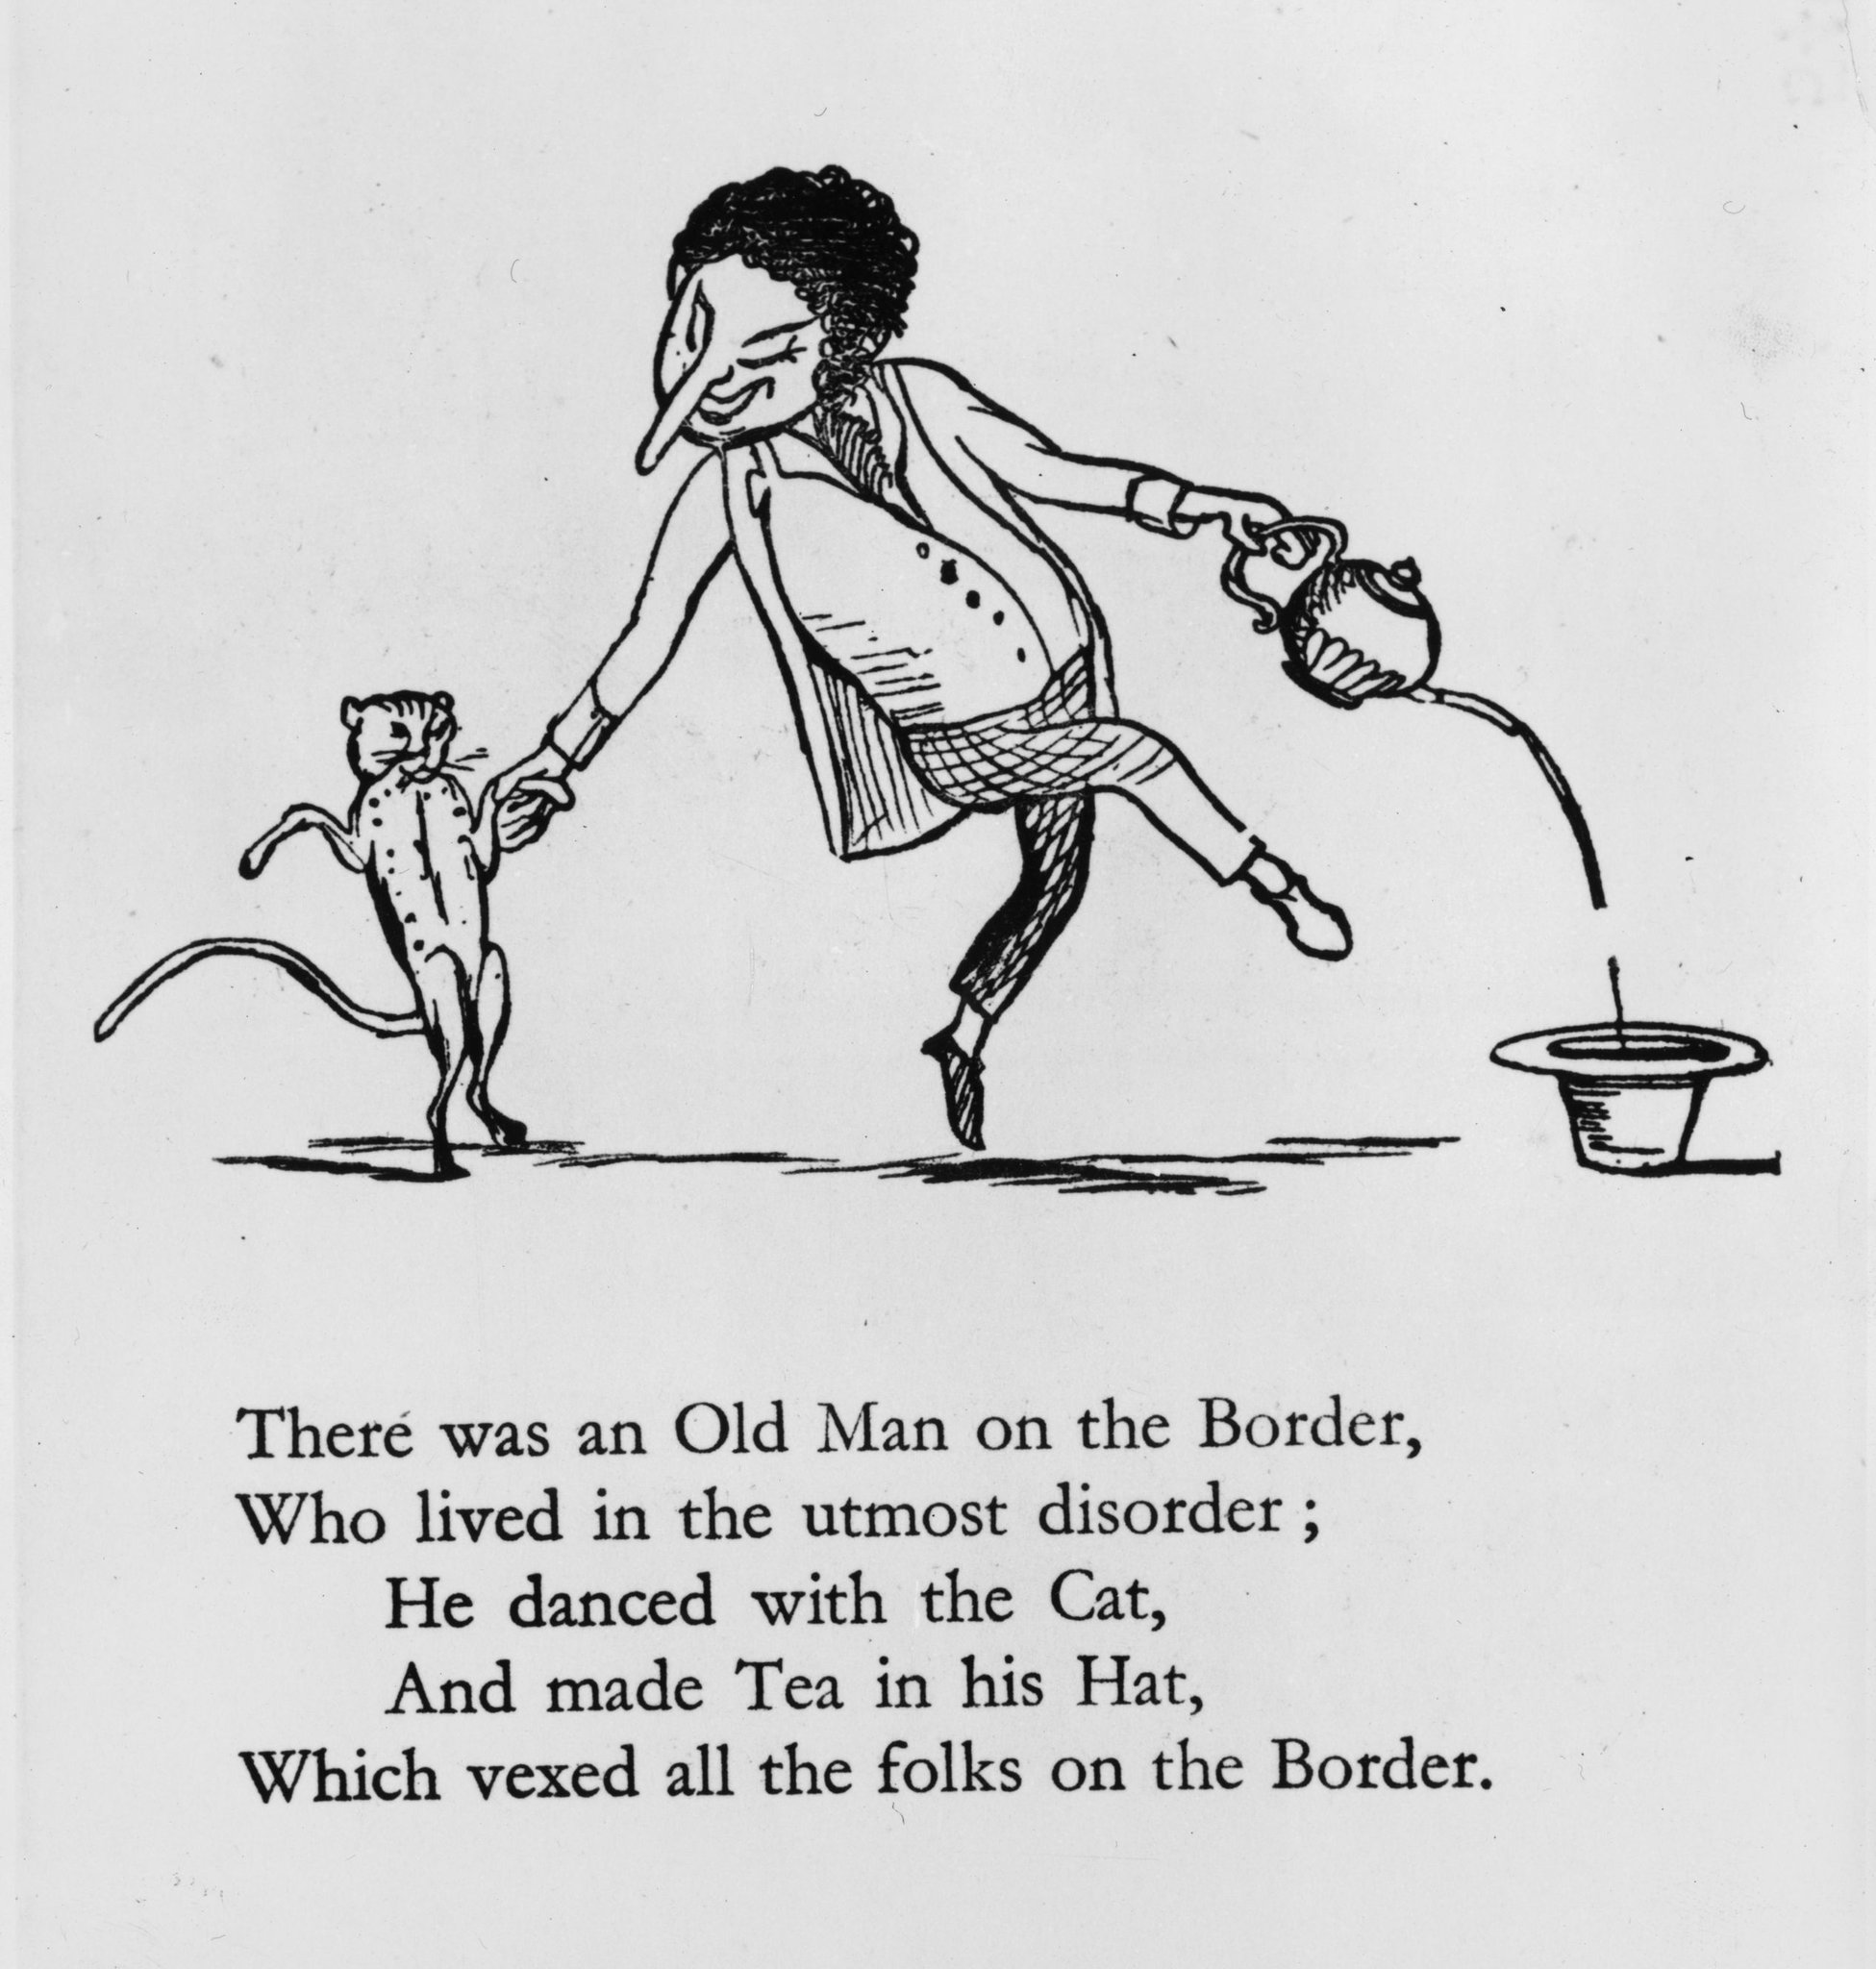

</center>
    
Lear's writing is particularly well-suited to text generation because of its playful and nonsensical nature. Lear often made use of invented words, portmanteaus, and other forms of wordplay, and his writing style is characterized by a sense of whimsy and playfulness that lends itself well to creative exploration.

Ready to get started? Let's dive in!
    
</div>

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.1 - Reading & Cleaning the Text**
    
Read the contents of the file `data/edward_lear.txt` and store it in a variable called `text_raw`. The text contained in this file is an excerpt of content made available thanks to [Project Gutenberg](https://www.gutenberg.org/) and is distributed under their licence. Project Gutenberg is a great place to find texts for NLP projects.
    
    
*(The full text they distribute, data/pg13650.txt, is included in our files to adhere to their licence.)*
    
<br>    
    
Next, implement a function `text_clean` that converts a string to lowercase and replace any number of contiguous whitespace characters with a single space (e.g., `'\n\n'` -> `' '`). Use it on `text_raw` and save the result as `text`. This will make our langauge modeling task a bit simpler and the output of our text generation easier to read.
</div>

In [12]:
# file I/O commands
with open("data/edward_lear.txt", "r") as file:
    text_raw = file.read()

In [13]:
def text_clean(corpus):
    #convert string to lowercase
    corpus = corpus.lower()
    #replace any number of contiguous whitespace characters with a single space
    #\n\n --> ''
    #I can use a regular expression to do so
    cleaned_corpus = re.sub(r"\s+", " ", corpus)
    return cleaned_corpus
text = text_clean(text_raw)

In [14]:
# Display length of cleaned corpus
print(f"Corpus length: {len(text):,}")

Corpus length: 133,762


In [15]:
# test = "Hello  "
# text_clean(test)

In [16]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.2 - Character-Integer Mappings**

We will be building a character-level language model. Instead of treating words as tokens, we will treat each individual character as a token. This approach allows for more granular modeling of text, but it comes at the expense of increased computational complexity.

To make this possible, we need to create two-way character to integer mappings. We will assign each unique character in our text a unique integer identifier, and we will use this integer identifier to represent the character in our neural network. 

Your task is to create a sorted list called `chars` of all the unique characters in the processed `text` variable. Then, create two dictionaries: `char2idx` and `idx2char`. `char2idx` should map each unique character to its unique integer identifier, which is the index at which that character appears in `chars`. Conversely, `idx2char` should map each integer identifier to its corresponding unique character. These mappings will be essential for feeding our text data into the neural network, which requires numeric data.
</div>


In [17]:
for string in text:
    print(string)

a
 
b
o
o
k
 
o
f
 
n
o
n
s
e
n
s
e
 
b
y
 
e
d
w
a
r
d
 
l
e
a
r
.
 
w
i
t
h
 
a
l
l
 
t
h
e
 
o
r
i
g
i
n
a
l
 
p
i
c
t
u
r
e
s
 
a
n
d
 
v
e
r
s
e
s
 
[
i
l
l
u
s
t
r
a
t
i
o
n
]
 
t
h
e
r
e
 
w
a
s
 
a
n
 
o
l
d
 
d
e
r
r
y
 
d
o
w
n
 
d
e
r
r
y
,
 
w
h
o
 
l
o
v
e
d
 
t
o
 
s
e
e
 
l
i
t
t
l
e
 
f
o
l
k
s
 
m
e
r
r
y
;
 
s
o
 
h
e
 
m
a
d
e
 
t
h
e
m
 
a
 
b
o
o
k
,
 
a
n
d
 
w
i
t
h
 
l
a
u
g
h
t
e
r
 
t
h
e
y
 
s
h
o
o
k
 
a
t
 
t
h
e
 
f
u
n
 
o
f
 
t
h
a
t
 
d
e
r
r
y
 
d
o
w
n
 
d
e
r
r
y
.
 
o
r
i
g
i
n
a
l
 
d
e
d
i
c
a
t
i
o
n
.
 
t
o
 
t
h
e
 
g
r
e
a
t
-
g
r
a
n
d
c
h
i
l
d
r
e
n
,
 
g
r
a
n
d
-
n
e
p
h
e
w
s
,
 
a
n
d
 
g
r
a
n
d
-
n
i
e
c
e
s
 
o
f
 
e
d
w
a
r
d
,
 
1
3
t
h
 
e
a
r
l
 
o
f
 
d
e
r
b
y
,
 
t
h
i
s
 
b
o
o
k
 
o
f
 
d
r
a
w
i
n
g
s
 
a
n
d
 
v
e
r
s
e
s
 
(
t
h
e
 
g
r
e
a
t
e
r
 
p
a
r
t
 
o
f
 
w
h
i
c
h
 
w
e
r
e
 
o
r
i
g
i
n
a
l
l
y
 
m
a
d
e
 
a
n
d
 
c
o
m
p
o
s
e
d
 
f
o
r
 
t
h
e
i
r
 
p
a
r
e
n
t
s
.
)
 
i
s
 
d
e
d
i
c
a
t
e
d
 
b
y
 
t
h
e
 


In [18]:
# sorted unique char list
#each string in text is precisely a character
chars = []
for string in text:
    if string not in chars:
        chars.append(string)
    else:
        continue
chars[0:5]

['a', ' ', 'b', 'o', 'k']

In [19]:
# char<>index mappings
char2idx = {}
idx2char = {}

for idx, char in enumerate(chars):
    char2idx[char] = idx

char2idx

{'a': 0,
 ' ': 1,
 'b': 2,
 'o': 3,
 'k': 4,
 'f': 5,
 'n': 6,
 's': 7,
 'e': 8,
 'y': 9,
 'd': 10,
 'w': 11,
 'r': 12,
 'l': 13,
 '.': 14,
 'i': 15,
 't': 16,
 'h': 17,
 'g': 18,
 'p': 19,
 'c': 20,
 'u': 21,
 'v': 22,
 '[': 23,
 ']': 24,
 ',': 25,
 'm': 26,
 ';': 27,
 '-': 28,
 '1': 29,
 '3': 30,
 '(': 31,
 ')': 32,
 '8': 33,
 '6': 34,
 '2': 35,
 '*': 36,
 '"': 37,
 '!': 38,
 'z': 39,
 "'": 40,
 'q': 41,
 '?': 42,
 'x': 43,
 'j': 44,
 ':': 45,
 'ô': 46,
 '_': 47,
 '5': 48,
 '0': 49,
 '7': 50,
 '4': 51,
 '/': 52,
 'ò': 53,
 'è': 54,
 '&': 55,
 'ö': 56}

In [20]:
for idx, char in enumerate(chars):
    idx2char[idx] = char
idx2char

{0: 'a',
 1: ' ',
 2: 'b',
 3: 'o',
 4: 'k',
 5: 'f',
 6: 'n',
 7: 's',
 8: 'e',
 9: 'y',
 10: 'd',
 11: 'w',
 12: 'r',
 13: 'l',
 14: '.',
 15: 'i',
 16: 't',
 17: 'h',
 18: 'g',
 19: 'p',
 20: 'c',
 21: 'u',
 22: 'v',
 23: '[',
 24: ']',
 25: ',',
 26: 'm',
 27: ';',
 28: '-',
 29: '1',
 30: '3',
 31: '(',
 32: ')',
 33: '8',
 34: '6',
 35: '2',
 36: '*',
 37: '"',
 38: '!',
 39: 'z',
 40: "'",
 41: 'q',
 42: '?',
 43: 'x',
 44: 'j',
 45: ':',
 46: 'ô',
 47: '_',
 48: '5',
 49: '0',
 50: '7',
 51: '4',
 52: '/',
 53: 'ò',
 54: 'è',
 55: '&',
 56: 'ö'}

In [21]:
# Display number of unique chars
print("Total chars:", len(chars))

Total chars: 57


In [22]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.3 - Input Sequence and Target Pairs**

Now that we have our character to integer mappings, we can begin creating our input sequence and target pairs. This process involves breaking up our text into fixed-length sequences, where each sequence is used to predict the character that follows that sequence in the text. 

Your task is to implement the code to generate these input sequence and target pairs using the following hyperparameters:
- `SEQ_LEN`: the length of each input sequence (default 100)
- `STEP`: the stride between each sequence (default 1)
    
For example, suppose our input text is "the owl and the pussy-cat went to sea". If `SEQ_LEN` is 5 and `STEP` is 2, we will create the following input sequences and target pairs:

| input sequence | target pair |
|---|---|
| `['t', 'h', 'e', ' ', 'o']` | `'w'` |
| `['e', ' ', 'o', 'w', 'l']` | `' '` |
| `['o', 'w', 'l', ' ', 'a']` | `'n'` |
| `['l', ' ', 'a', 'n', 'd']` | `' '` |
| `['a', 'n', 'd', ' ', 't']` | `'h'` |
| `['d', ' ', 't', 'h', 'e']` | `' '` |
| `['t', 'h', 'e', ' ', 'p']` | `'u'` |
| `['e', ' ', 'p', 'u', 's']` | `'s'` |
| `['p', 'u', 's', 's', 'y']` | `'-'` |
| `['s', 's', 'y', '-', 'c']` | `'a'` |
| `['y', '-', 'c', 'a', 't']` | `' '` |
| `['c', 'a', 't', ' ', 'w']` | `'e'` |
| `['t', ' ', 'w', 'e', 'n']` | `'t'` |
| `['w', 'e', 'n', 't', ' ']` | `'t'` |
| `['n', 't', ' ', 't', 'o']` | `' '` |
| `[' ', 't', 'o', ' ', 's']` | `'e'` |

You will need to create two numpy arrays: `x` and `y`. `x` should be an integer numpy array of shape (num_sequences, `SEQ_LEN`), where num_sequences is the total number of input sequences. Each element of `x` should be an integer representing the character at that position in the input sequence. `y` should be an integer numpy array of shape (num_sequences,), where each element is the integer representation of the target character for the corresponding input sequence.

After you have generated `x` and `y`, print their shapes and data types.
</div>

In [23]:
len(text)

133762

In [24]:
# your code here
SEQ_LEN = 100
STEP = 1
#x essentially is the design matrix of input data. each row is a specific
#sequence, and the columns is the number of characters in a sequence, 100 in this case

#essentially, more efficient loop
#for i in range(0, len(text), 100)] which means that i will loop
#iteratively over the len of the text every 100 characters
# sequences = [text[i:i+100] for i in range(0, len(text), 1)] 
target_list = []
all_sequences = []
#range goes (start,end,step)
for i in range(0, len(text)-100, 1):
    slice = text[i:i+100]
    all_sequences.append(slice)
    target = text[i+100]
    target_list.append(target)

In [25]:
num_sequences = len(all_sequences)
num_sequences

133662

In [26]:
#133662 rows and 100 columns
# array_2d = np.vstack((array1, array2))
#convert characters in all the sequences to index values
global_index_list = []
for sequence in all_sequences:
    specific_index = []
    for character in sequence:
        character = char2idx[character]
        specific_index.append(character)
    global_index_list.append(specific_index)
        

In [27]:
x = np.array(global_index_list)

In [28]:
y = np.array(target_list)

In [29]:
y
#apparently these b's are byte strings

array(['s', ' ', 'a', ..., 'r', '!', '"'], dtype='<U1')

In [30]:
y_copy = y

In [31]:
# Now convert to integer token IDs using your char2idx dict
# y_int = np.array([char2idx[char] for char in y_clean], dtype=np.int32)
y = np.array([char2idx[char] for char in y_copy], dtype = np.int32)

In [32]:
y

array([ 7,  1,  0, ..., 12, 38, 37], dtype=int32)

In [33]:
# Display info of input sequences and targets
print("Number of sequences:", len(x))
print("x shape:", x.shape)
print("y shape:", y.shape)

Number of sequences: 133662
x shape: (133662, 100)
y shape: (133662,)


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.4 - Creating a TensorFlow Dataset Pipeline**

Now that we have prepared our input-output data, we need to create a TensorFlow dataset pipeline to feed it into our recurrent neural network. TensorFlow datasets provide an efficient and flexible way to handle large amounts of data and are particularly useful when working with deep learning models.

To create a TensorFlow dataset pipeline from our input-output data, we will use the `tf.data.Dataset.from_tensor_slices` method. This method takes a tuple of arrays or tensors and returns a dataset of slices along the first dimension. 

To optimize our training process, we will also shuffle our data, batch it into smaller chunks, and prefetch it to keep the GPU busy while the CPU is preparing the next batch. These operations should be performed in the following order: shuffle, batch, prefetch. Save this pipeline as `dataset`.

</div>


In [34]:
# your code here
dataset = tf.data.Dataset.from_tensor_slices((x,y))
#get two batches, size of single batch = 256
dataset = dataset.shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

2025-04-16 10:51:47.265559: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:236] Using CUDA malloc Async allocator for GPU: 0
2025-04-16 10:51:47.266928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:31:00.0, compute capability: 8.9


In [35]:
# check the dataset
for x, y in dataset.take(2):
    print("x shape:", x.shape)
    print("y shape:", y.shape)

x shape: (256, 100)
y shape: (256,)
x shape: (256, 100)
y shape: (256,)


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.5 - Recurrent Neural Network**

Now it's time to build and compile our recurrent neural network! 

Your task is to construct a model with the Keras API that has the following architecture:

- The model should include at least one type of recurrent unit (check imports for some options).
- The output layer should have a `softmax` activation function, and output a probability distribution over each of the possible characters.
- Compile the model with an appropriate optimizer and loss function for the task.
- Display a summary of the model's architecture.

Make sure to consider the dimensions of `x` and `y` when constructing the model, and pay close attention to the input and output shape of the layers.
    
**Hints:**
- Your input sequences are currenlty sequences of intergers which are far from ideal and will likely lead to very poor performance. You could one-hot encode each character in the sequence as a sparse vector, but that (1) takes up more memory and (2) means all characters are orthogonal to one another. The best option would be to explore [Keras's Embedding layer](https://keras.io/api/layers/core_layers/embedding/) which will convert your integer input sequences into sequences of learnable, non-sparse vectors, allowing the model to represent some characters as similar to one another.
- Your targets are integers. You could one hot encode them to use categorical cross entropy as a loss, but this also takes up more memory. Better to explore what your [other loss options](https://keras.io/api/losses/) are for a scenario like this.
- Please feel free to experiement in your search for an optimal architecture and set of hyperparameters, but its bets to start of simple. In the final question of part 1 you will discuss the various approaches you tried.
</div>

In [36]:
# your code here
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model

#should do Functional API b/c dataset code up above 
#SEQ_LEN = 100
#VOCAB_SIZE = len(char2idx) 
#EMBED_DIM = 64 -- this can be random 64 or 128

dataset_input = keras.Input(shape=(100,))
#we need embedding because RNN's can't take discrete inputs like 5, but need continuous vectors
#embedding dimension = 64 means that every single character/token becomes a vector of dimension 64
#each row of 100 characters, or sequence, becomes 100x64 matrix
#so embedding is like what each token means

# Input:     (32, 100)        → integers (token IDs)
# Embedding: (32, 100, 64)    → vector per token
# LSTM:      (32, 128)        → one 128-dim vector per sequence
# Dense:     (32, vocab_size) → probability distribution over next character

embedding = keras.layers.Embedding(input_dim = len(char2idx), output_dim = 64)(dataset_input)
#LSTM is what the entire sequence means
#it also compresses
rnn_output = layers.LSTM(128)(embedding)
#final dense layer which is one neuron per character, so we need softmax
#want the model to predict the next character in a sequence, our y
output = layers.Dense(len(char2idx), activation = 'softmax')(rnn_output)

#build model in Functional API
model = keras.Model(inputs = dataset_input, outputs = output)

#compile model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#get model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 64)           3648      
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 57)                7353      
                                                                 
Total params: 109817 (428.97 KB)
Trainable params: 109817 (428.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.6 - Temperature**
    
When generating text with a language model, we want to balance between predictability and randomness. We use the notion of temperature to control the amount of randomness in the text. Here's how it works:

Given a probability distribution of the next character, the temperature is applied as a scaling factor to the log probabilities. This is done to adjust the shape of the distribution. A higher temperature means a flatter distribution, where all characters are equally likely, and a lower temperature means a sharper distribution, where the most probable character has a higher probability.

Your task is to implement a function called `sample` which takes in three arguments: `preds` - the probability distribution of the next character, `temperature` - the temperature to be applied, and `eps` - a small value to prevent us from taking the log of zero. It should return an integer corresponding to the index of the sampled character. Here's the formula for the sampling probabilities when applying temperature:

$$
\text{probas} = \frac{\exp{\big[\log{(\text{preds}_i)}\ /\ T\big]}}{\sum_j{\exp{\big[\log{(\text{preds}_j)}\ /\ T\big]}}}
$$
 
You will likely want to make use of numpy's logarithm and exponential functions as well as `np.random.multinomial` to implement `sample`.
    
</br>

**Note:** to avoid issues with numerical precission it may be necessary to convert `preds` to type np.float64.

In [37]:
#probas will change my logits via applying temperature
#then, with these probas, I want to create a distribution -- which is where np.random.multinomial comes in
#helps me create and sample from this random distribution of probabilities
def sample(preds, temperature=1.0, eps=1e-10):
    # your code here
    #to convert an array of integers to array of floats 
    preds = np.asarray(preds).astype(np.float64)

    #use the function described above to generate the probabilities with temperature applied
    probas = (np.exp(np.log(preds)/temperature))/np.sum(np.exp(np.log(preds)/temperature))

    sample = np.random.multinomial(1,probas)
    sampled_index = np.argmax(sample)
    
    return sampled_index

In [38]:
grader.check("q1.6")

q1.6 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.7 - Text Generation Callback**

As we train our recurrent neural network, we want to be able to monitor its progress and see how well it is doing at each epoch. Looking at the loss can tell us if the model is improving, but it doesn't give us an idea of what the generated text looks like. By generating example text during training, we can get a sense of whether the model is producing text that is coherent and in the style of the training corpus.
    
Implement a function `generate_text` to be used as part of a lambda callback at the end of each training epoch.
    
**Function arguments**
- `epoch`: integer representing the current epoch number.
- `_`: internal keras callback parameter (not used in this function).

**Output**
- Prints generated strings and their corresponding temperatures.

**Function requirements**
- For each temperature value in `[0.2, 0.5, 1.0]`, perform the following steps:
    1. Sample a random, 'seed' sequence from the training data
    2. Print the seed sequence.
    3. Generate a string with 400 characters by iteratively:
        1. Predict the next character distribution by passing the numerically encoded seed sequence using the model.
        2. Use the `sample` function with the chosen temperature to select a character from the predicted distribution.
        3. Append the selected character to the end of the seed sequence and drop the first character.
    4. Print the generated string and its corresponding temperature.

Here is an example implementation scaffold of `generate_text` that you can use as a reference:
```python
def generate_text(epoch, _):
    print()
    print("Generating text after epoch: %d" % epoch)
    
    for temperature in [0.2, 0.5, 1.0]:
        print("...Temperature:", temperature)

        # Step 1: Sample a random starting index from the training text.
        ...

        # Step 2: Retrieve the seed sequence from the training text.
        ...
        # Step 3: Print the seed sequence.
        print('...Generating with seed: "' + seed + '"')

        # Initialize an empty string to store the generated text.
        generated = ""

        # Generate 200 characters.
        for i in range(200):
            ...
```
    
</div>

In [39]:
x

<tf.Tensor: shape=(256, 100), dtype=int64, numpy=
array([[ 1, 16, 17, ...,  2,  0,  7],
       [ 5,  1, 10, ..., 19,  3,  7],
       [ 0,  6,  1, ..., 15,  6,  4],
       ...,
       [13, 15, 16, ...,  8, 12,  7],
       [ 3,  6, 24, ..., 15,  6, 18],
       [ 1,  3, 13, ..., 12, 19, 15]])>

In [40]:
train = pd.DataFrame(x)

Function arguments

epoch: integer representing the current epoch number.
_: internal keras callback parameter (not used in this function).
Output

Prints generated strings and their corresponding temperatures.
Function requirements

For each temperature value in [0.2, 0.5, 1.0], perform the following steps:
1. Sample a random, 'seed' sequence from the training data
   
2. Print the seed sequence.

3. Generate a string with 400 characters by iteratively:

    4. Predict the next character distribution by passing the numerically encoded seed sequence using the model.

    5. Use the sample function with the chosen temperature to select a character from the predicted distribution.

    6. Append the selected character to the end of the seed sequence and drop the first character.

7. Print the generated string and its corresponding temperature.




In [41]:
def generate_text(epoch, _):
    print()
    print("Generating text after epoch: %d" % epoch)
    
    for temperature in [0.2, 0.5, 1.0]:
        print("...Temperature:", temperature)

        # Step 1: Sample a random starting index from the training text.
        #a starting index from the training text would begin after a period, which is index 14 in the x
        #oh I could also just iterate through my x dataframe which has all the sequences
        #so iterate through the rows
        #random.choice(x.index)
        ...
        sampled_index = np.random.choice(train.index)

        # Step 2: Retrieve the seed sequence from the training text.
        seed = train.loc[sampled_index]
        #I need to print out the seed as a string 
        #I use the .join
        seed_str = ''.join([idx2char[i] for i in seed])
        # Step 3: Print the seed sequence.
        print('...Generating with seed: "' + seed_str + '"')
        
        # Initialize an empty string to store the generated text.
        generated = ""

        # Generate 200 characters.
        #so I want my model to predict the next character following being fed
        #this happens during training so no need to train right now, just predict. I will feed this genrate_text function 
        #during training
        for _ in range(200):
            #chatGPT told me to add this
            input_seq = np.expand_dims(seed, axis=0)
            #have to have the model predict on this sequence
            #as the model output is a softmax, it will give me the probabilities of different words that follow the sequence
            preds = model.predict(input_seq, verbose=0)[0]
            #however, to introduce randomness and to avoid looping words, have to sample
            #so proba is a list of porbabilities for each word in the vocabulary
            #sample will return to me the predicted token, which is an integer
            predicted_token = sample(preds, temperature = temperature, eps=1e-10)
            #now have to convert the integer to character
            character = idx2char[predicted_token] 
            generated += character
            #Update the seed (slide the window) -- from ChatGPT
            seed = np.concatenate([seed[1:], [predicted_token]]).astype(np.int32)
        print(generated)
        #want output to be generated string  and corresponding temperature

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.8 - Training the Model with Lambda Callback**

Now that you have created a dataset pipeline, constructed your RNN, and implemented a function to generate text, it's time to train your RNN model on the data!

In order to monitor the training progress, use the `generate_text` function that you implemented in the previous question as part of a `LambdaCallback` to generate some sample text at 3 different temperature at the end of each epoch.

After training for at least 5 epochs, plot the training loss across epochs.
</div>

In [42]:
from tensorflow.keras.callbacks import LambdaCallback
#ChatGPT code
# def on_epoch_end(epoch, logs):
#     print(f"\n\n--- Generating text after Epoch {epoch + 1} ---")   
#     generated = generate_text(epoch, _)
#     print(generated)

generate_callback = LambdaCallback(on_epoch_end=generate_text)


In [43]:
# Training the RNN
#dataset 
history = model.fit(dataset, epochs = 10, callbacks = [generate_callback])
# model.fit(dataset, epochs = 10, callbacks = [generate_callback])
# model.fit(dataset, epochs=10, callbacks=[generate_callback])

Epoch 1/10


2025-04-16 10:51:52.605269: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-16 10:51:53.133787: I external/local_xla/xla/service/service.cc:168] XLA service 0x14b93c0c7b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-16 10:51:53.133820: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-04-16 10:51:53.139686: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  4/523 [..............................] - ETA: 17s - loss: 4.0315 - accuracy: 0.1279  

I0000 00:00:1744815113.429168   10918 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


517/523 [============================>.] - ETA: 0s - loss: 2.6021 - accuracy: 0.2791
Generating text after epoch: 0
...Temperature: 0.2
...Generating with seed: "suvius. [illustration] there was an old man of dundee, who frequented the top of a tree; when distur"
 and a the she and and and and and and a cathe the and and and ar the ond and and and and an and a the and and and and and and and and and and and and a the and a he sathe sa the bus and and and and a
...Temperature: 0.5
...Generating with seed: "der and ruder, till at last with a hammer they silenced his clamor. by smashing that person of buda."
 the sope om cas ind a ind the le thas uis pos this win out ace cas ale th at ont she was an and whe the bale he bang the she and and and in sead ar sheo ho lume sas he the moure a tin al sall whe sas
...Temperature: 1.0
...Generating with seed: " old man of melrose." [illustration] there was an old man of the dee, who was sadly annoyed by a fle"
lt re teiusgers thand thel helbr atmes

**PLOT THE TRRAINING LOSS**

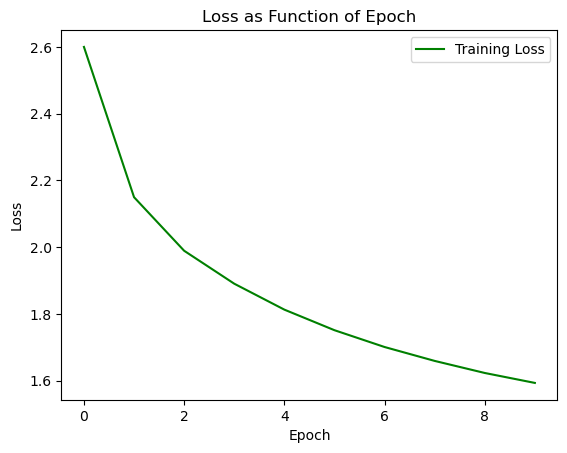

In [44]:
# 
plt.plot(history.history['loss'], label = 'Training Loss', color = 'green')
# plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss as Function of Epoch')
plt.legend()
plt.show()

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.9 - Perplexity for Language Models**
    
In natural language processing, perplexity is a commonly used metric to evaluate the quality of language models. It measures how well a model predicts a sequence of words (or characters in the case of our RNN), given a sequence of words. 
    
Perplexity is a measure of how surprised a model is to see an unseen sequence of words. It is related to entropy, a concept from information theory that measures the amount of information in a probability distribution. In fact, perplexity can be interpreted as the exponentiation of the entropy of a language model.
    
The formula for perplexity is:
    
$$\text{Perplexity} = 2^{-\frac{1}{N} \sum_{i=1}^N \log_2 P(w_i | w_1^{i-1}) }$$
    
where $N$ is the number of words (or characters) in the test set, and $P(w_i | w_1^{i-1})$ is the probability of the $i$-th word given the previous $i-1$ words.
    
A lower perplexity score indicates that the model is better at predicting the next word in a sequence. A perfect model would have a perplexity of 1, indicating that it is not at all surprised to see the next word in the sequence.
    
To implement a perplexity function for your character-level RNN, you can follow these steps:
1. Pass a sequence of input characters through the model to get the predicted probability distribution for the next character.
2. Calculate the cross-entropy loss between the predicted probability distribution and the actual target character.
3. Accumulate the loss for each character in the test set.
4. Compute the average loss across all characters in the test set.
5. Compute the perplexity score by exponentiating the average loss.
    
Below is a skeleton implementation for a possible perplexity function that takes in a trained model and a dataset of test sequences. The function returns the perplexity score of the model on the provided dataset. While less than ideal, because we have only the one small corpus, we will calculate perplexity on the training data.
    
```python
def calculate_perplexity(model, dataset):
    total_loss = 0
    steps = 0 # number of chars predicted on so far
    
    for x, y in dataset:
        # Get predictions from the model
        ...
        
        # Flatten the targets and predictions to 2D arrays
        ...
        
        # Calculate the loss and add it to the running total
        ...
        
    # Calculate the average loss and perplexity
    avg_loss = ...
    perplexity = ...
    
    return perplexity
```

**Hints:**
    
- If the calculation is slow you may consider adding an optional `batch_size` argument to your function which will `unbatch` and then re-batch the dataset with a higher batch size.
- You may be able to make use of a loss from `keras.losses` as part of your calculation
- If you are encoutering nans or infs you should make sure you are using higher precision variable types (e.g., `tf.float64`) to avoid under/overflow issues.
    
</div>

To implement a perplexity function for your character-level RNN, you can follow these steps:

1. Pass a sequence of input characters through the model to get the predicted probability distribution for the next character.
2. Calculate the cross-entropy loss between the predicted probability distribution and the actual target character.
3. Accumulate the loss for each character in the test set.
4. Compute the average loss across all characters in the test set.
5. Compute the perplexity score by exponentiating the average loss.

In [47]:
# !pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [50]:
def calculate_perplexity(model, dataset, batch_size=64):
    total_loss = 0
    steps = 0 # number of chars predicted on so far
    total_tokens = 0
    for x, y in dataset:
        # Get predictions from the model
        probs = model.predict(x, verbose=0)
        y_true = y#can leave this as it is
        # print(probs.shape)
        # print(y_true.shape)
        # Flatten the targets and predictions to 2D arrays
        
        # Calculate the loss and add it to the running total
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, probs)
        # total_loss+=loss
        total_loss += tf.reduce_sum(loss).numpy()
        total_tokens += np.prod(y.shape)  # total number of tokens
        # This converts the per-sample
        # loss tensor (shape (batch_size,)) into a single scalar,
        # then adds it to your total_loss as a float.
    avg_loss = total_loss/total_tokens

    perplexity = np.power(avg_loss, 2)
        # print(loss)
        
    # Calculate the average loss and perplexity
    # avg_loss = ...
    # perplexity = ...
    
    return perplexity

# perplexity = ...

In [51]:
calculate_perplexity(model,dataset)

2.5726474750151764

In [52]:
# Display final train perplexity
print(f"Train Perplexity: {calculate_perplexity(model,dataset):.2f}")

Train Perplexity: 2.57


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.10 - Model Assessment**
    
Now, it's time to see what kind of wacky and wonderful text your model can generate!

Write any string of `SEQ_LEN` characters and use it as a seed to generate a longer sequence of text (at least 400 additional characters). Do this for at least 3 temperatures using the same seed. 
    
Next, discuss your approach to arriving at your final model architecture and hyperparameters. What did you find worked well based on loss, perplexity, and text generation, and what approaches didn't help or even made things worse?

Finally, assess how well your model generates text in the style of the Edward Lear corpus. Are there any noticeable patterns or quirks in the generated text? Did your model successfully capture the whimsical and nonsensical style of Edward Lear's writing?

</div>

In [53]:
custom_string = "The sun dipped below the horizon, painting the sky in hues of orange, pink, and fading blue. I found"

In [54]:
custom_string = custom_string.lower()

In [55]:
for temperature in [0.2,0.5,1.0]:
    seed = custom_string
    #create integer embedding of string via
    #idx2char
    seed = [char2idx[i] for i in seed]
    generated = ""
    for _ in range(400):
            #chatGPT told me to add this
            input_seq = np.expand_dims(seed, axis=0)
            #have to have the model predict on this sequence
            #as the model output is a softmax, it will give me the probabilities of different words that follow the sequence
            preds = model.predict(input_seq, verbose=0)[0]
            #however, to introduce randomness and to avoid looping words, have to sample
            #so proba is a list of porbabilities for each word in the vocabulary
            #sample will return to me the predicted token, which is an integer
            predicted_token = sample(preds, temperature = temperature, eps=1e-10)
            #now have to convert the integer to character
            character = idx2char[predicted_token] 
            # print("This is the predicted character ", character)
            # print("Printing text a")
            generated += character
            seed = np.append(seed[1:], predicted_token).astype(np.int32)

            #Update the seed (slide the window) -- from ChatGPT
            # seed = np.concatenate([seed[1:], [predicted_token]]).astype(np.int32)
    print("Temperature is: ", temperature)
    print(generated)

Temperature is:  0.2
 a bottle beat the stor a bottle and a stree, when the was the mond of the said, "i a little beat a little beat a bong of the who said, "the said, "i has the said, "who had the crown a bottle with a stree the was the could person of the said, "whis he said, "it a carter a little some the said, "it the could a bot the stor of the said, "the paid the purs he said, "it it was a sing a little person o
Temperature is:  0.5
 a came a mill of the and with rangle in the mound of the ponds of that his the more of the mones, and the peath the pumble and his lived in the streat with reat his he stord, and who went deed wather dead, the poss of the parking place of the stratter his herser a love a see is a crangle with a bottle and gree to the tate a ling of two more on the wose hat the proped of she clarked in the streen 
Temperature is:  1.0
 of sither bomet, pam-dieves, that awalal muced of wither chrond young page praizt whablet; and quaky jove, and, what alond his with do

In [56]:
#from chatGPT - 
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create the scheduler
lr_schedule = ReduceLROnPlateau(
    monitor='loss',           # You can also use 'val_loss'
    factor=0.5,               # Reduce LR by this factor
    patience=2,               # After how many epochs of no improvement
    verbose=1,                # Print a message when it reduces LR
    min_lr=1e-6               # Don’t go lower than this
)


In [57]:
#thomas model
# Embedding layer 64
# LSTM w out 256
# Dense 512 rely
# Dense to output

new_model_input = keras.Input(shape=(100,))

new_embedding = keras.layers.Embedding(input_dim = len(char2idx), output_dim = 128)(new_model_input)
#LSTM is what the entire sequence means
#it also compresses

# Under the hood, Bidirectional will copy the RNN layer passed in, 
# and flip the go_backwards field of the newly copied layer, 
# so that it will process the inputs in reverse order.

new_rnn_output = tf.keras.layers.Bidirectional(layers.LSTM(256))(new_embedding)
new_dense = layers.Dense(512,activation = 'relu')(new_rnn_output)
new_output = layers.Dense(len(char2idx), activation = 'softmax')(new_dense)
#build model in Functional API
new_model = keras.Model(inputs = new_model_input, outputs = new_output)

#compile model
new_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#get model summary
new_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 128)          7296      
                                                                 
 bidirectional (Bidirection  (None, 512)               788480    
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 57)                29241     
                                                                 
Total params: 1087673 (4.15 MB)
Trainable params: 1087673 (4.15 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [58]:
new_model.fit(dataset, epochs = 10, callbacks = [lr_schedule])

Epoch 1/10
523/523 [==============================] - 11s 18ms/step - loss: 2.4467 - accuracy: 0.3112 - lr: 0.0010
Epoch 2/10
523/523 [==============================] - 9s 16ms/step - loss: 1.8104 - accuracy: 0.4664 - lr: 0.0010
Epoch 3/10
523/523 [==============================] - 9s 16ms/step - loss: 1.5923 - accuracy: 0.5244 - lr: 0.0010
Epoch 4/10
523/523 [==============================] - 9s 16ms/step - loss: 1.4460 - accuracy: 0.5632 - lr: 0.0010
Epoch 5/10
523/523 [==============================] - 9s 16ms/step - loss: 1.3246 - accuracy: 0.5966 - lr: 0.0010
Epoch 6/10
523/523 [==============================] - 9s 16ms/step - loss: 1.2192 - accuracy: 0.6259 - lr: 0.0010
Epoch 7/10
523/523 [==============================] - 9s 16ms/step - loss: 1.1223 - accuracy: 0.6539 - lr: 0.0010
Epoch 8/10
523/523 [==============================] - 9s 16ms/step - loss: 1.0267 - accuracy: 0.6805 - lr: 0.0010
Epoch 9/10
523/523 [==============================] - 9s 16ms/step - loss: 0.9250 - acc

In [59]:
for temperature in [0.2,0.5,1.0]:
    seed = custom_string
    #create integer embedding of string via
    #idx2char
    seed = [char2idx[i] for i in seed]
    generated = ""
    for _ in range(400):
            #chatGPT told me to add this
            input_seq = np.expand_dims(seed, axis=0)
            #have to have the model predict on this sequence
            #as the model output is a softmax, it will give me the probabilities of different words that follow the sequence
            preds = new_model.predict(input_seq, verbose=0)[0]
            #however, to introduce randomness and to avoid looping words, have to sample
            #so proba is a list of porbabilities for each word in the vocabulary
            #sample will return to me the predicted token, which is an integer
            predicted_token = sample(preds, temperature = temperature, eps=1e-10)
            #now have to convert the integer to character
            character = idx2char[predicted_token] 
            # print("This is the predicted character ", character)
            # print("Printing text a")
            generated += character
            seed = np.append(seed[1:], predicted_token).astype(np.int32)

            #Update the seed (slide the window) -- from ChatGPT
            # seed = np.concatenate([seed[1:], [predicted_token]]).astype(np.int32)
    print("Temperature is: ", temperature)
    print(generated)

/tmp/ipykernel_8445/3961416808.py:10: RuntimeWarning: divide by zero encountered in log
  probas = (np.exp(np.log(preds)/temperature))/np.sum(np.exp(np.log(preds)/temperature))


Temperature is:  0.2
 of the angry bong-reg said, "an owl and he wrapped him by the crumpetty tree and a great gromboolian planes or dark and should be see that they all them all the moon weather one said, "some it ony said, "what a white and of statished her hater and his back and pea-green jambles, the akond of swat? is he tould he was all the pussy-cat, the akond of swat? does he have them all the pobble of this al
Temperature is:  0.5
 the moon water, and all of the crumpetty tree the whole of the catch and gander in grandic and who caught a bit on a sofast, last and but his beat of the lakes of the pallent of the wonder had her turks of the parening the pumpkin ats with a small remortance, the akond of swat? does he turn is a bark and book, and a pipe of the pobble who has no the sea, it has one a country, and beat his happy o
Temperature is:  1.0
 of she delight resommend onwer-wich manner dore as endight, nat, mr. quicked and pipe, to keep her in mind a fish, form he saily had a

In [61]:
calculate_perplexity(new_model, dataset)

0.5446045820770291

Next, discuss your approach to arriving at your final model architecture and hyperparameters. What did you find worked well based on loss, perplexity, and text generation, and what approaches didn't help or even made things worse?

Finally, assess how well your model generates text in the style of the Edward Lear corpus. Are there any noticeable patterns or quirks in the generated text? Did your model successfully capture the whimsical and nonsensical style of Edward Lear's writing?

**My approach to arriving at my final model architecture was the following**
1. Add a Bidirectional LSTM layer - which let the model learn from both past and future content instead of restricting itself to only prior words.
2. Increased output_dim = 128 - gave my model more capacity to learn character-level features
3. LSTM(128) increaased to LSTM(256) - gave the model more memory and stronger sequence modeling ability.
4. Added Dense(512, activation = 'relu') layer - Allowed the model to learn complex non-linear combos before predictions
5. Learning Rate Scheduling and Callback - Automatically adjusted learning rate during training based on how my model was performing.

All of the following worked well, some more than others. Without the learning rate scheduling my model performed worse but with it it's clear to see that within 10 epochs it did not change -- which I guess points to the fact that either I need to train on more epochs to see a potential plateau where LR scheduling can significantly help or the optimal learning rate is just 0.1. These techniques increased my accuracy substantially and also helped me achieve a perplexity score of 0.5.

What did not work well was adding dropout -- that actually worsened my training performance so I removed it from the final model architecture.

**Assessing Model Performance in Style of Edward Lear**
I believe my model's accuracy, around 75%, reflects my model's ability to capture Edward Lear's style -- for instance, the model reflects the semantics and onomonopea of Lear's writing (he dots his dead on all the dops type deal). However, my model did not correctly get down the rhyme scheme, AABBA, that Lear uses. My model does use punctuation quite a bit like Lear; frequent exclamation points, lots of quotes in the middle of sentences, etc. Overall, my model has a lot of room for improvement, but it's got the basic trends of Lear's writing somewhat down. 

Super cool! 

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">
    
### **PART 2: Named Entity Recognition**
    
Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 
    
In the first part of the homework, you will build such a named entity classifier.  
    
The dataset consists of sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. For this homework, we will only use the ```Word``` and ```Tag``` columns. 
    
Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity
    
Named entity recognition is a type of "many-to-many" problem, refering to the fact that the model takes in a sequence of input tokens and produces a sequence of output tags, with potentially many input tokens mapping to many output tags, and vice versa. This contrasts with "many-to-one" models, where a sequence of input tokens maps to a single output (as in part 1), and "one-to-many" models, where a single input maps to a sequence of outputs.

---
    
First, read the dataset into a pandas dataframe using the provided code below.
</div>

In [64]:
# Load the NER data
file_path = "https://storage.googleapis.com/cs109b/nlp/ner_dataset.csv"
data = pd.read_csv(file_path,
                   encoding="latin1")
data = data.fillna(method="ffill")
print("Shape:",data.shape)
data.head(15)

/tmp/ipykernel_8445/3732270100.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


Shape: (1048575, 4)


Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O

<a id="part2"></a>
<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

### **2.1 PREPROCESS THE DATASET**

Of course, it wouldn't be a real NLP task without some preprocessing!
    
**2.1.1 - Creating the Vocabulary**
    
Create a list of unique words found in the 'Word' column, sorted it in alphabetic order, and call it `words`. Store the length of this list as ```n_words```. **Print your results for `n_words`**.
<br />
    
**Note:** Do not modify word capitalization, nor remove any numerical or special characters.
</div>

In [65]:
# your code here
words = []
#want to loop through the words column, append to words if unique, continue if not
for word in data["Word"]:
    if word not in words:
        words.append(word) 

words.sort()
n_words = len(words)

In [66]:
# Run this cell to show your results for n_words
print(f'n_words: {n_words}')

n_words: 35177


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.2 - Unique Tags**
    
Create a list of unique tags and sort it in alphabetic order and store it in the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**.

</div>

In [67]:
# your code here
tags = []
for tag in data["Tag"]:
    if tag not in tags:
        tags.append(tag)

tags.sort()
n_tags = len(tags)

In [68]:
# Run this cell to show your results for n_tags
print(n_tags)

17


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.3 - Sentences of Input-Target Pairs**
    
As mentioned above, NER is a many-to-many problem where for each input token in a sequence the model will try and predict the corresponding taget entity tag.
    
Process the data into a list, `sentences`, where each element of the list is itself a list of (word, tag) tuples. Here is an example of what the first sentence in the list should look like:

```
[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
```
</div>

In [69]:
# your code here
#creating a list of lists essentially
#the inner list is the sentence, and for each element of that list is a tuple of word and NER tag

#so I want to loop through both the words and tag column of data at the same time and join the two into a tuple

#first need to group the dataset by sentence so I can efficiently discriminate between sentences
grouped = data.groupby("Sentence #")

sentences = []
for _, group in grouped:
    sentence = list(zip(group["Word"], group["Tag"]))
    sentences.append(sentence)


In [70]:
# display you first sentence
sentences[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.4 - Maximum Sentence Length**
    
Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**
    
</div>

In [71]:
# your code here

max_len = max(len(sentence) for sentence in sentences)

In [72]:
# Run this cell to show your results for max_len
print(max_len)

104


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.5 - Word Encoding**
    
It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary that performs inverse mapping.
    
**IMPORTANT:** Your indices should start at `1`. We will reserve `0` for later to represent padding.
    
</div>

In [73]:
# your code here
# chars = []
# for string in text:
#     if string not in chars:
#         chars.append(string)
#     else:
#         continue
# chars[0:5]

# char2idx = {}
# idx2char = {}

# for idx, char in enumerate(chars):
#     char2idx[char] = idx

# char2idx

word2idx = {}
idx2word = {}

for idx, word in enumerate(words, start = 1):
    #I think enumerate returns value, key
    word2idx[word] = idx #the value of this key, which is the word, is the index

word2idx

{'!': 1,
 '"': 2,
 '#': 3,
 '#NAME?': 4,
 '$': 5,
 '%': 6,
 '%-plus': 7,
 '&': 8,
 "'": 9,
 "'70s": 10,
 "'80s": 11,
 "'T": 12,
 "'d": 13,
 "'ll": 14,
 "'m": 15,
 "'n": 16,
 "'re": 17,
 "'s": 18,
 "'ve": 19,
 '(': 20,
 ')': 21,
 ',': 22,
 '-': 23,
 '--': 24,
 '.': 25,
 '..': 26,
 '...': 27,
 '.tv': 28,
 '/': 29,
 '0': 30,
 '0-3': 31,
 '0-6': 32,
 '0.01': 33,
 '0.02': 34,
 '0.04': 35,
 '0.050474537': 36,
 '0.051655093': 37,
 '0.060092593': 38,
 '0.068171296': 39,
 '0.068217593': 40,
 '0.068263889': 41,
 '0.068275463': 42,
 '0.068472222': 43,
 '0.08': 44,
 '0.1': 45,
 '0.110474537': 46,
 '0.110625': 47,
 '0.12': 48,
 '0.161': 49,
 '0.17': 50,
 '0.19': 51,
 '0.193': 52,
 '0.2': 53,
 '0.3': 54,
 '0.35': 55,
 '0.4': 56,
 '0.5': 57,
 '0.55': 58,
 '0.6': 59,
 '0.65': 60,
 '0.7': 61,
 '0.8': 62,
 '0.82': 63,
 '0.9': 64,
 '01-Feb': 65,
 '01-Jan': 66,
 '01-Jun': 67,
 '02-Feb': 68,
 '02-Jan': 69,
 '02-Jun': 70,
 '02-May': 71,
 '03-Apr': 72,
 '03-Feb': 73,
 '03-Jan': 74,
 '03-Jun': 75,
 '03-Mar': 

In [74]:
# \for idx, char in enumerate(chars):
#     idx2char[idx] = char
# idx2char

for idx, word in enumerate(words, start = 1):
    idx2word[idx] = word #the value of this key will be the word
idx2word

{1: '!',
 2: '"',
 3: '#',
 4: '#NAME?',
 5: '$',
 6: '%',
 7: '%-plus',
 8: '&',
 9: "'",
 10: "'70s",
 11: "'80s",
 12: "'T",
 13: "'d",
 14: "'ll",
 15: "'m",
 16: "'n",
 17: "'re",
 18: "'s",
 19: "'ve",
 20: '(',
 21: ')',
 22: ',',
 23: '-',
 24: '--',
 25: '.',
 26: '..',
 27: '...',
 28: '.tv',
 29: '/',
 30: '0',
 31: '0-3',
 32: '0-6',
 33: '0.01',
 34: '0.02',
 35: '0.04',
 36: '0.050474537',
 37: '0.051655093',
 38: '0.060092593',
 39: '0.068171296',
 40: '0.068217593',
 41: '0.068263889',
 42: '0.068275463',
 43: '0.068472222',
 44: '0.08',
 45: '0.1',
 46: '0.110474537',
 47: '0.110625',
 48: '0.12',
 49: '0.161',
 50: '0.17',
 51: '0.19',
 52: '0.193',
 53: '0.2',
 54: '0.3',
 55: '0.35',
 56: '0.4',
 57: '0.5',
 58: '0.55',
 59: '0.6',
 60: '0.65',
 61: '0.7',
 62: '0.8',
 63: '0.82',
 64: '0.9',
 65: '01-Feb',
 66: '01-Jan',
 67: '01-Jun',
 68: '02-Feb',
 69: '02-Jan',
 70: '02-Jun',
 71: '02-May',
 72: '03-Apr',
 73: '03-Feb',
 74: '03-Jan',
 75: '03-Jun',
 76: '03-Ma

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.6 - Prepare X**
    
Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sentence encoded as a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
<br />
    
</div>

In [75]:
sentences

[[('Thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('London', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('Iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('British', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')],
 [('Iranian', 'B-gpe'),
  ('officials', 'O'),
  ('say', 'O'),
  ('they', 'O'),
  ('expect', 'O'),
  ('to', 'O'),
  ('get', 'O'),
  ('access', 'O'),
  ('to', 'O'),
  ('sealed', 'O'),
  ('sensitive', 'O'),
  ('parts', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('plant', 'O'),
  ('Wednesday', 'B-tim'),
  (',', 'O'),
  ('after', 'O'),
  ('an', 'O'),
  ('IAEA', 'B-org'),
  ('surveillance', 'O'),
  ('system', 'O'),
  ('begins', 'O'),
  ('functioning', 'O'),
  ('.', 'O')],
 [('Helicopter', 'O'),
  ('gunships', 'O'),
  ('Saturday', 'B-tim'),
  ('pounded', 'O'

In [76]:
# your code here
# Prepare predictors list of lists
X = []
for sentence in sentences:
    encoded_sentence = [word2idx[word] for word, tag in sentence]
    X.append(encoded_sentence)
X

[[15077,
  27700,
  20969,
  24218,
  26434,
  33389,
  9685,
  33464,
  29396,
  33246,
  34660,
  24853,
  8205,
  17364,
  20924,
  33246,
  34973,
  27700,
  4011,
  33786,
  23512,
  33242,
  20368,
  25],
 [8194,
  27727,
  31033,
  33289,
  22577,
  33464,
  23723,
  16665,
  33464,
  31142,
  31319,
  28267,
  27700,
  33246,
  28646,
  16052,
  22,
  16915,
  17349,
  7925,
  32879,
  32985,
  18238,
  23555,
  25],
 [7599,
  24039,
  13559,
  28905,
  26765,
  24370,
  24853,
  33246,
  11665,
  33744,
  30130,
  22,
  34856,
  26426,
  14822,
  26768,
  17663,
  18261,
  33464,
  24218,
  23164,
  33464,
  17982,
  17349,
  21856,
  26776,
  27714,
  24853,
  27286,
  14309,
  16040,
  25],
 [15049, 25892, 16915, 16574, 33179, 24592, 32312, 34971, 30717, 28756, 25],
 [15424,
  30227,
  20254,
  8421,
  5853,
  30957,
  14607,
  22,
  15442,
  22,
  8086,
  17364,
  3150,
  26776,
  24318,
  17663,
  22934,
  27959,
  23270,
  17364,
  32815,
  33464,
  30276,
  17665,
  2770

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.7 - Pad X**
    
Apply the keras ```pad_sequences``` function to standardize the length of input sequences and "pre" pad them with `0`. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. 
</div>

In [77]:
# your code here
# Apply the keras pad_sequences function
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_padded = pad_sequences(X, maxlen=max_len, padding='pre',value=0)
# X_padded = pad_sequences(X, maxlen=max_len, padding='pre', value=0)
X = X_padded
# print(max_len)
# print(X_padded.shape)
# print(X_padded)


In [78]:
# Run this cell to show your results #
print("Sentence 2: {}\n".format(X[0]))
print(X.shape)

Sentence 2: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0 15077 27700 20969 24218
 26434 33389  9685 33464 29396 33246 34660 24853  8205 17364 20924 33246
 34973 27700  4011 33786 23512 33242 20368    25]

(47959, 104)


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1. - Tag Encoding**
    
Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.
<br />
    
**IMPORTANT:** Your indices should start at `1`. We will reserve `0` for later to represent padding.
</div>

In [79]:

tag2idx = {}
idx2tag = {}

for idx, tag in enumerate(tags, start = 1):
    tag2idx[tag] = idx

for tag, idx in enumerate(tags, start = 1):
    idx2tag[tag] = idx
# idx2tag
# tag2idx

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.9 - Prepare Y**

Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
<br />
    
</div>

In [80]:
# your code here
Y = []
for sentence in sentences:
    encoded_tag = [tag2idx[tag] for word, tag in sentence]
    Y.append(encoded_tag)

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.10 - Pad Y**
    
Apply the keras ```pad_sequences``` function to standardize the target sequences and 'pre' pad them with zeros. You should retrieve a matrix with all padded sentences' tags and length equal to the ```max_length``` previously computed. 
<br />
    
</div>

In [81]:
# your code here
# Apply the kera pas_sequences function
Y = pad_sequences(Y, maxlen = max_len, padding = 'pre', value = 0)

In [82]:
Y.shape

(47959, 104)

In [83]:
X.shape

(47959, 104)

In [84]:
X

array([[    0,     0,     0, ..., 33242, 20368,    25],
       [    0,     0,     0, ..., 18238, 23555,    25],
       [    0,     0,     0, ..., 14309, 16040,    25],
       ...,
       [    0,     0,     0, ..., 17482, 20967,    25],
       [    0,     0,     0, ..., 33246, 23819,    25],
       [    0,     0,     0, ..., 23789,    25,     2]], dtype=int32)

In [85]:
Y

array([[ 0,  0,  0, ..., 17, 17, 17],
       [ 0,  0,  0, ..., 17, 17, 17],
       [ 0,  0,  0, ...,  3, 11, 17],
       ...,
       [ 0,  0,  0, ..., 17, 17, 17],
       [ 0,  0,  0, ..., 17, 17, 17],
       [ 0,  0,  0, ..., 17, 17, 17]], dtype=int32)

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**2.1.11 - Train / Validation / Test Split**
    
From the original dataset, construct a training, validation, and test set.
    
You should do this by making 2 calls to `train_test_split`. First, by splitting of 10% into test. Then by splitting 10% of what remains into validation with the rest being use for training. Use `random_state=109` for both your splits.
    
**Hint:** You may choose to turn your train and validation data into tensorflow Dataset objects for efficient training as in part 1.
    
</div>

In [86]:
from sklearn.model_selection import train_test_split

# Step 1: 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, Y, test_size=0.10, random_state=109)

# Step 2: 10% of remaining for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.10, random_state=109)


BATCH_SIZE = 128

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(BATCH_SIZE)
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(BATCH_SIZE)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# import tensorflow as tf

# BATCH_SIZE = 32

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

### **2.2 MODELLING THE DATA**

**2.2.1 - Build and fit the NER Model**

Now that you've prepared the train and test sets, you'll build a recurrent model which will include:

- An Embedding layer with input dimension equal to the number of unique tokens in the input sequences and output (embedding) dimension of 50
- A dropout layer with a dropout rate you find works well
- A Bidirectional Gated Recurrent Unit (GRU) layer where each direction's hidden state has a dimension of 100
- The final Dense layer (i.e., output layer) will have `units` equal to the number of unique tokens in the target sequences and an appropriate activation (consider the target dimensions).

After compiling the model, display the summary, train until you think you have achieved good results based on the loss and or any metrics you may be monitoring, and plot the training history.

**Hints:**
    
- We used `0` as our padding token. You can use `mask_zero=True` in the embedding layer to skip over any zeros in the input.  This will increase training speed (we also aren't interested in predicting the padding anyway).
- Remember that you have zeros in both your input and target sequences because of the padding. This will effect affect the required input and output dimensions of the network *even if you choose to mask the zeros*.
- Don't forget that this is a many-to-many problem where you are outputting sequences. Consider how this determines at least one argument required by your recurrent layer.
</div>

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, GRU, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [88]:
#define model params
vocab_size = len(word2idx) + 1      # +1 because indexing starts at 1; 0 is for <PAD>
num_tags = n_tags + 1            # number of unique tags (including 'O', 'B-geo', etc.)
embedding_dim = 50
hidden_dim = 100

In [89]:
vocab_size

35178

In [90]:
#right so the whole point of this RNN is to predict the tag of 
#the following word in a sequence
model = Sequential()
#embedding layer 
model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = max_len, mask_zero=True))

#add dropout layer
model.add(Dropout(0.3))

#BiDirectional layer GRU
model.add(Bidirectional(GRU(units=hidden_dim,return_sequences=True)))


#output layer 
model.add((Dense(num_tags,activation = 'softmax')))
                  

model.compile(optimizer=Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# model.summary

In [91]:
# Run this cell to show your results #
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 104, 50)           1758900   
                                                                 
 dropout (Dropout)           (None, 104, 50)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 104, 200)          91200     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 104, 18)           3618      
                                                                 
Total params: 1853718 (7.07 MB)
Trainable params: 1853718 (7.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [92]:

history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)


Epoch 1/5


2025-04-16 11:12:54.695010: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_37/output/_22'


304/304 [==============================] - 79s 240ms/step - loss: 0.5867 - accuracy: 0.8762 - val_loss: 0.2346 - val_accuracy: 0.9378
Epoch 2/5
304/304 [==============================] - 59s 195ms/step - loss: 0.1630 - accuracy: 0.9545 - val_loss: 0.1393 - val_accuracy: 0.9598
Epoch 3/5
304/304 [==============================] - 60s 198ms/step - loss: 0.1102 - accuracy: 0.9681 - val_loss: 0.1224 - val_accuracy: 0.9644
Epoch 4/5
304/304 [==============================] - 59s 194ms/step - loss: 0.0905 - accuracy: 0.9730 - val_loss: 0.1153 - val_accuracy: 0.9659
Epoch 5/5
304/304 [==============================] - 59s 195ms/step - loss: 0.0791 - accuracy: 0.9758 - val_loss: 0.1135 - val_accuracy: 0.9664


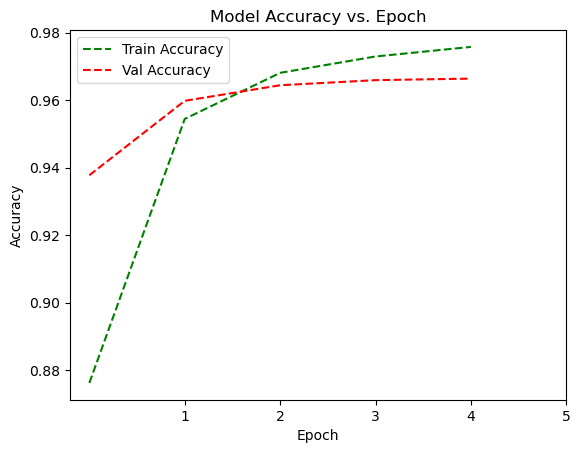

In [93]:
# Plot the training history
# your code here
plt.plot(history.history['accuracy'], label = "Train Accuracy", color = 'g', linestyle = '--')
plt.plot(history.history['val_accuracy'], label = "Val Accuracy", color = 'r', linestyle = '--')
plt.xlabel('Epoch')
plt.xticks(list(range(1,6)))
plt.ylabel('Accuracy')
plt.title("Model Accuracy vs. Epoch")
plt.legend()
plt.show()

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**2.2.2 - Visualizing the Latent Space**

Some would argue that neural networks are all about representation learning. Let's see how your network represents each sequences.
    
Visualize outputs from the bidirectional GRU layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.
    
You can make use of the two functios provided below to make your plots, but make sure you understand the arguments taken by `get_hidden_ouput_PCA`, especially `index_layer`, the index of the layer in your network whose outputs we want to visualize, and `out_dim`, the output dimensions of that layer at a single timestep.

</div>

In [94]:
# Helper functions
# Note: updated function requires y_test as an argument
def visualize_B_I(pca_result, y_test):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = y_test.flatten()
    unique_categories = np.unique(category)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in unique_categories[8*i:8*(i+1)]:
            indices = np.where(category==cat+1)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat+1],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("PC1")
        ax[i].set_ylabel("PC2")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")


def get_hidden_output_PCA(model, X_test, y_test, layer_index, out_dimension):
    latent_space_extractor = Model(model.inputs, model.layers[layer_index].output)
    hidden_feature=np.array(latent_space_extractor([X_test]))

    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print(f'Variance explained by PCA: {np.sum(pca.explained_variance_ratio_):.2%}')
    return pca_result

In [95]:
# output shape = (batch_size, max_len, 2 * hidden_dim) = (batch_size, max_len, 200)

In [96]:
# your code here
pca_result = get_hidden_output_PCA(model, X_test, y_test, 2, 200)
pca_result

Variance explained by PCA: 82.26%


array([[-1.2536851 , -0.09541035],
       [-1.2536343 , -0.09482554],
       [-1.2536343 , -0.09481303],
       ...,
       [ 6.8619304 ,  0.02433211],
       [ 6.1543097 , -0.8195645 ],
       [ 5.5644464 , -3.0465481 ]], dtype=float32)

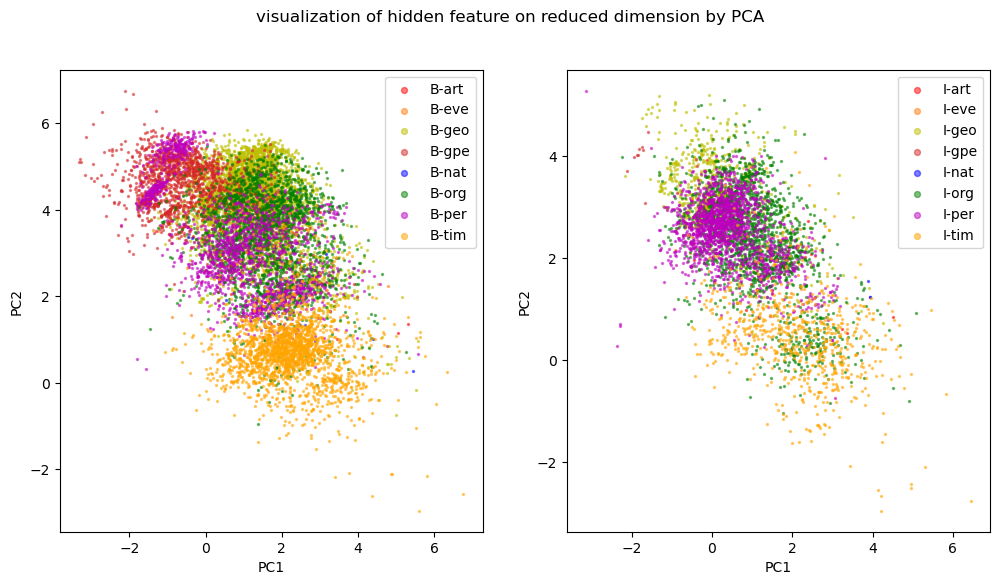

In [97]:
visualize_B_I(pca_result, y_test)

Each point is a hidden state vector (per word) projected to 2D using PCA.
Each color represents a named entity class

The left plot is for all beginning tags and the right plot is for all inside tags

I see distinct blobs of clusters in both plots, which indicates that my model has learned to separate these tags/entities based on type. AKA it is learning the meaningful representations of the human syntax, or representative learning. I see this more so on the left plot than the right, however, both trends are still there, especially with this slope or curved effect in the representation effect. So my model also has consistency in how it represents entities.

For example on the left plot, "B-per" and "B-eve" are densely clustered, suggesting the model is learning meaningful representations of people and events.

To summarize, my model, or more sepcifically my BiDirectional GRU Layer, is learning to distinguish entities in a meaningful and representative way.

<a id="part1"></a>
<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
### **2.3 MODEL ANALYSIS**
    
**2.3.1 - Computing & Plotting F1 Scores**

Let's get a better sense of how well out model is doing at predicting each of the different tag categories.
    
Use your trained NER model to predict on the test dataset. Compute an F1 score for each unique ```Tag``` category and store them in `f1_scores`.
    

The use a well-labeled bar plot to visualize the model's test F1 scores for each Tag category.

</div>

In [98]:
# Calculate F1 scores
# Your code here
y_pred = model.predict(X_test, verbose = 1)
#probably going to select the max probability to determine class - so I should do argmax axis = -1 to reduce 3rd dim
y_pred = y_pred.argmax(axis=-1)

#F1 score can only be computed for 1d array so flatten these 2d arrays
y_pred = y_pred.flatten()
y_true = y_test.flatten()

150/150 [==============================] - 7s 37ms/step


In [99]:
#ChatGPT remove padding code
mask = y_true != 0
y_pred_masked = y_pred[mask]
y_true_masked = y_true[mask]


In [100]:
#obtaining the actual tags for my predictions and true y test values so  Ican do classification report
y_pred_tags = [idx2tag[i] for i in y_pred_masked]
y_true_tags = [idx2tag[i] for i in y_true_masked]

In [101]:
from sklearn.metrics import classification_report

print(classification_report(y_true_tags, y_pred_tags, digits=4))


/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       B-art     0.0000    0.0000    0.0000        37
       B-eve     0.0000    0.0000    0.0000        38
       B-geo     0.8631    0.8858    0.8743      3651
       B-gpe     0.9607    0.9308    0.9455      1576
       B-nat     1.0000    0.1176    0.2105        17
       B-org     0.7673    0.7325    0.7495      2120
       B-per     0.8576    0.8068    0.8314      1672
       B-tim     0.9157    0.8750    0.8949      2024
       I-art     0.0000    0.0000    0.0000        16
       I-eve     0.0000    0.0000    0.0000        33
       I-geo     0.7872    0.7895    0.7884       703
       I-gpe     0.8750    0.4667    0.6087        15
       I-nat     0.0000    0.0000    0.0000         4
       I-org     0.7726    0.7928    0.7826      1766
       I-per     0.8758    0.8209    0.8474      1658
       I-tim     0.7863    0.7114    0.7470       693
           O     0.9871    0.9928    0.9900     88575

    accuracy              

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

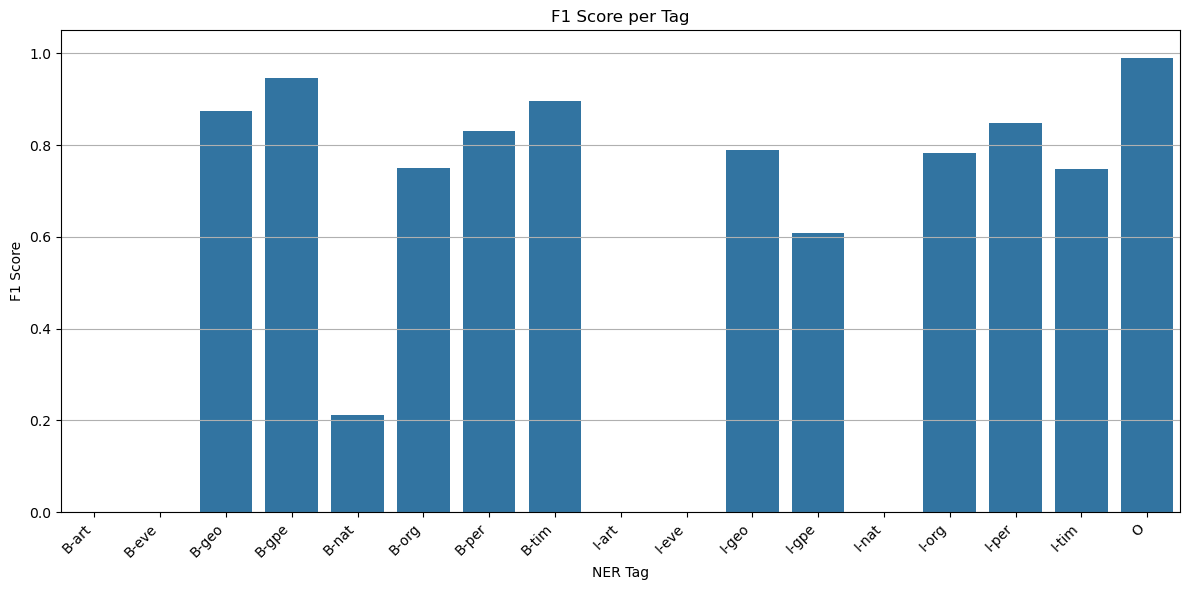

In [102]:
# Plot F1 scores
# Your code here
import seaborn as sns
report = classification_report(y_true_tags, y_pred_tags, output_dict=True)
# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Filter out non-tag rows
tag_rows = report_df.index[report_df.index.str.startswith(('B-', 'I-', 'O'))]
f1_scores = report_df.loc[tag_rows]['f1-score']

plt.figure(figsize=(12, 6))
sns.barplot(x=f1_scores.index, y=f1_scores.values)
plt.xticks(rotation=45, ha='right')
plt.title("F1 Score per Tag")
plt.xlabel("NER Tag")
plt.ylabel("F1 Score")
plt.ylim(0, 1.05)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**2.3.2 - Discussion**

Briefly discuss the performance of the model across the various tag categoies. Does anything stand out to you about the visualization. Does it seem like a problem? If so, what might be done to address this in future iterations of the NER model?

</div>

In [103]:
values, counts = np.unique(y_train, return_counts = True)
print(dict(zip(values,counts)))

{0: 3189498, 1: 326, 2: 242, 3: 30599, 4: 12933, 5: 167, 6: 16264, 7: 13839, 8: 16506, 9: 247, 10: 196, 11: 6021, 12: 171, 13: 40, 14: 13557, 15: 14069, 16: 5255, 17: 720054}


Looking at the F1 scores plot I can infer some powerful things about the model performance across the various tag categories. 

1. The F1 score for some tags is zero. This means that either precision = 0, which would mean out of all the predicted specific tag (where f1 score is zero), all of them were incorrect. Or recall = 0, which would mean that none of these specific tags, where f1 score is zero, were predicted correctly. I mean essentially this points to the fact that my model did not correctly classify these tags.

2. I can infer this occurs for a few reasons. 1. Imbalanced Dataset -- the model is biased towards other tags because they are more common. 2. The model predicts wrong but similar tags

I believe the first bullet is the issue, that there is an imbalanced dataset. An imbalanced dataset is super common in NER datasets - some tags are just more likely than others. In this case, my model has not been trained on enough examples of these uncommon tags to correctly predict them. If we look above, it is clear to see there is heavy imbalance in the dataset. Look at tags 1,2, 9, 10, 13. They are measured on the hundreds scale whilst other tags are measured at tens of thousands or thousands. Expectedly, these are all the tags with an F1 score of zero. So this seems to be our issue -- the class imbalance leading to precision or recall = 0

There are two ways to deal with this
1. Undersampling majority class tags and oversampling minority class tags
2. Or blanket overweight the minority class (adjust the loss function to penalize errors on minority classes more heavily.). This can be done using sample_weight in keras. 



<a id="part3"></a>
<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
    
### **Part 3: Pre-Trained Transformers for Text Classification**

Throughout CS1090A and CS1090B, we've modeled many classification tasks using various machine learning algorithms. NLP has several sub-fields/popular problems that are largely treated as classification tasks, such as sentiment analysis, natural language entailment, and generic '*text classification*' like spam detection. Moreover, *nearly all* NLP problems have at least some classification component.

In part 2 of this assignment, we will focus on using *transformers* for text classification, a popular and powerful technique in NLP. Transformers are a type of neural network architecture that has gained widespread popularity in recent years due to their ability to effectively model long-range dependencies in text.

In the real world, one common text classification task is the **Systematic Review**, a process of classifying research papers for a particular research topic. In this part of this assignment, you will implement a text classifier for the Systematic Review process.

Medical research is produced at an astronomical rate, with [a few thousand articles published daily](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3191655/). Conducting a proper literature search can be unwieldy and overwhelming, requiring very carefully crafted search terms, and sifting through several thousand results. A doctor reads the **abstracts** of thousands of candidate papers, looking for potentially useful research papers. Often, the Systematic Review only yields a handful of useful research papers, and the others are considered **irrelevant**.

If the Systematic Review yields many useful papers, then one might be able to conduct a *Meta Analysis*, allowing one to draw new insights and research conclusions from the myriad of independent, regionalized research through the world. So, one needs to be incredibly meticulous when reading through thousands of abstracts. NLP can assist in this task by helping to classify papers as relevant or irrelevant.

In this real-life situation, an infectious disease doctor is researching sexually transmitted infections (STIs) in women who have HIV and are living in sub-Saharan Africa. STIs like gonorrhea and chlamydia are under-treated in low-resource communities. Because there aren't affordable and accessible STI testing in the area, there isn't population-wide screen. So, doctors don't have a good understanding of the epidemiology and prevalence of STIs -- especially amongst women who have HIV, which carries extra, serious health risks.
    
Let's build a text classifier to see if we can help find "**not irrelevant**" abstracts. We will train the model by providing many already-annotated abstracts, where each abstract is labelled as being either "*irrelevant*" or "*not irrelevant*". At test time, we will see if your model can help suggest which papers to strongly consider.

Note that the distinction between "*irrelevant*" and "*not irrelevant*" is not the same as the distinction between "*important*" and "*unimportant*". Some papers may be highly relevant to a particular research topic but not necessarily "*important*" in the sense of having groundbreaking findings or significant implications.

</div>

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

**3.1 - Loading the Abstract Data**

Load the data from the CSV files `review_78678_irrelevant.csv`, `review_78678_not_irrelevant_included.csv`, and `review_78678_not_irrelevant_excluded.csv` into 3 dataframes. For each dataframe, add a new column called `target` with a value of `0` for `review_78678_irrelevant.csv` and a value of `1` for the other two files. The CSV files can be found in the `./data` directory.
    
</div>

In [104]:
# your code here
irrelevant = pd.read_csv("data/review_78678_irrelevant.csv")
relevant_included = pd.read_csv("data/review_78678_not_irrelevant_included.csv")
relevant_excluded = pd.read_csv("data/review_78678_not_irrelevant_excluded.csv")

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
   
**3.2 - Combine the Dataframes**
    
Concatenate all the dataframes into a single dataframe. Keep only the columns `Abstract` and `target`. Apply `dropna()` on the dataframe. Name the final dataframe `all_data_df`.
</div>

In [105]:
# your code here
irrelevant['target'] = 0
relevant_included['target'] = 1
relevant_excluded['target']= 1

In [106]:
relevant_excluded.head()

Title  \
0  Human papillomaviruses prevalence and genital ...   
1  Vulnerability and risk factors for sexually tr...   
2  Prevalence and Detection of Trichomonas vagina...   
3  Twelve-Month Antiretroviral Therapy Suppresses...   
4  Sexual risk behaviour in a cohort of HIV-negat...   

                                             Authors  \
0  Sagna T.; Djigma F.; Zeba M.; Bisseye C.; Karo...   
1                   Råssjö EB.; Mirembe FM.; Darj E.   
2  Price CM.; Peters RPH.; Steyn J.; Mudau M.; Ol...   
3  Ondoa P.; Gautam R.; Rusine J.; Lutter R.; Jur...   
4  Mukanyangezi M.F.; Manzi O.; Tobin G.; Rulisa ...   

                                            Abstract  Published Year  \
0  The vaginal swabs among HIV-positive women in ...          2010.0   
1  Three hundred and six sexually experienced ado...          2006.0   
2  Trichomonas vaginalis is a sexually transmitte...          2018.0   
3  Genital viral load (GVL) is the main determina...          2015.0   
4  Here we wanted to assess whether sexual risk b...          2019.0   

  Published Month                                  Journal Volume  \
0             NaN  Pakistan Journal of Biological Sciences     13   
1             Oct                                AIDS care     18   
2              05            Sexually transmitted diseases     45   
3             NaN                                 PloS one     10   
4             NaN               Epidemiology and Infection    147   

                                               Issue     Pages  \
0                                                 19   951-955   
1                                                  7     710-6   
2                                                  5   332-336   
3                                                  5  e0127201   
4  (Giglio D., daniel.giglio@pharm.gu.se) Departm...       NaN   

  Accession Number                           DOI         Ref Covidence #  \
0              NaN     10.3923/pjbs.2010.951.955         NaN       #3109   
1              NaN     10.1080/09540120500302934  16971279.0       #1681   
2              NaN  10.1097/OLQ.0000000000000756  29465686.0       #1683   
3              NaN  10.1371/journal.pone.0127201  26010956.0       #1896   
4              NaN     10.1017/S0950268818003023         NaN       #4796   

               Study                                              Notes  Tags  \
0         Sagna 2010  Exclusion reason: 8. STI data inappropriate or...   NaN   
1        Råssjö 2006  Exclusion reason: 8. STI data inappropriate or...   NaN   
2         Price 2018  Exclusion reason: 2. Data overlap with other s...   NaN   
3         Ondoa 2015  Exclusion reason: 2. Data overlap with other s...   NaN   
4  Mukanyangezi 2019  Exclusion reason: 2. Data overlap with other s...   NaN   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [107]:
irrelevant[['Abstract','target']]
relevant_included[['Abstract','target']]
relevant_excluded[['Abstract','target']]

all_data_df = pd.concat([irrelevant[['Abstract','target']], relevant_included[['Abstract','target']], relevant_excluded[['Abstract','target']]], ignore_index=True)
all_data_df = all_data_df.dropna()

In [108]:
# Display summary information
print("Shape:",all_data_df.shape)
print(all_data_df.target.value_counts(normalize=True))
all_data_df.head()

Shape: (3693, 2)
target
0    0.852694
1    0.147306
Name: proportion, dtype: float64


Abstract  target
0  This study was carried out to know the prevale...       0
1  We attempted to determine the seropositivity o...       0
2  Human herpesvirus 8 (HHV-8) infection is commo...       0
3  338 women with age ranging from 15 to 69 years...       0
4  Antenatal screening and treatment for sexually...       0

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**3.3 - Train / Validation Split**

Use `train_test_split` to split the dataset into 90% train and 10% validation. You should stratify on the the target variable and use a random state of `109`. Name the resulting variables `train_x`, `validate_x`, `train_y`, and `validate_y`.

</div>



In [109]:
# your code here
from sklearn.model_selection import train_test_split

# Split features and target
X = all_data_df["Abstract"]
y = all_data_df["target"]

# Train/Validation Split (90/10), stratified
train_x, validate_x, train_y, validate_y = train_test_split(
    X, y,
    test_size=0.10,
    stratify=y,
    random_state=109
)


In [110]:
# Display split sizes
print("train_x count:", len(train_x))
print("validate_x count:", len(validate_x))

train_x count: 3323
validate_x count: 370


<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**3.4 - BERT Tokenization**
    
Per-trained models expect their inputs to have been processed in a particular way. We need to make sure we use the same tokenizer to processor data that was used to process the data our BERT model was trained on.
    
- Use `AutoTokenizer` to load the tokenizer for `'bert-base-uncased'`. Be sure to set `do_lower_case=True`.
- Use the tokenizer object to process both train and validation data, setting `max_length` to a value suitable for the dataset. It would need to be `<=512`.
- Save the processed input data as `train_x_processed` and `validate_x_processed`.

**Note:** The output from the tokenizer is a dictionary. We'll be interested in the keys `'input_ids'` and `'attention_mask'`.
</div>

In [111]:
# your code here
# from transformers import AutoTokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

max_length = 256


In [112]:
# your code here
train_x_processed = tokenizer(
    list(train_x),
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors="pt",         # or "tf" if you're using TensorFlow
    return_attention_mask=True
)

validate_x_processed = tokenizer(
    list(validate_x),
    padding='max_length',
    truncation=True,
    max_length=max_length,
    return_tensors="pt",
    return_attention_mask=True
)

In [113]:
# Display keys in processed input dictionary
print(train_x_processed.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [114]:
# Display shapes and examples of processed input
print("train_x_processed shape:", train_x_processed["input_ids"].shape)
print("validate_x_processed shape:", validate_x_processed["input_ids"].shape)
# First sample
print("First sample:")
print("input_ids:",train_x_processed["input_ids"][0][:10])
print("attention_mask:",train_x_processed["attention_mask"][0][:10])
# Second sample
print("Second sample:")
print("input_ids:",train_x_processed["input_ids"][1][:10])
print("attention_mask:",train_x_processed["attention_mask"][1][:10])

train_x_processed shape: torch.Size([3323, 256])
validate_x_processed shape: torch.Size([370, 256])
First sample:
input_ids: tensor([  101,  9415,  2224,  3464,  2152,  2426, 15101,  3360,  1998,  2402])
attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Second sample:
input_ids: tensor([  101,  2023,  3259, 22963,  1998, 23347,  2193,  1997,  5826,  1998])
attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

**3.5 - Dataset Pipeline** 
    
Build two tf.data pipelines: one for training and another validation. Follow this order when building pipelines:
  * Shuffle (if necessary) 
  * Batch
  * Prefetch

**Hint:** You can use the now familiar `from_tensor_slices` method to create your Tensorflow Dataset objects. But where as previously you've only needed to pass `x` and `y` as a tuple, here you will need to pass the input ids, attention mask, and the target variable as a 3-tuple.
</div>

In [115]:
# Construct your dataset pipeline
# # your code here
# train_data = tf.data.Dataset.from_tensor_slices((train_x_processed["input_ids"], 
#                                                     train_x_processed["attention_mask"],
#                                                     train_x_processed["token_type_ids"])).shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

In [116]:
# validation_data = tf.data.Dataset.from_tensor_slices((validate_x_processed["input_ids"], 
#                                                     validate_x_processed["attention_mask"],
#                                                     validate_x_processed["token_type_ids"])).shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

In [117]:
# ChatGPT code -- need to pass in the data as a dictionary not just the 3-tuple 
train_data = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_x_processed["input_ids"],
        "attention_mask": train_x_processed["attention_mask"],
        "token_type_ids": train_x_processed["token_type_ids"]
    },
    train_y
)).shuffle(10000).batch(16).prefetch(tf.data.AUTOTUNE)

validation_data = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": validate_x_processed["input_ids"],
        "attention_mask": validate_x_processed["attention_mask"],
        "token_type_ids": validate_x_processed["token_type_ids"]
    },
    validate_y
)).batch(32).prefetch(tf.data.AUTOTUNE)


In [118]:
# Display some pipeline info
print("train_data:\n", train_data)
print("validation_data:\n", validation_data)

train_data:
 <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
validation_data:
 <_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;"> 

**3.6 - Build Pre-Trained BERT**

Build and compile the pretrained `'bert-base-uncased'` model using [TFAutoModelForSequenceClassification](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodelforsequenceclassification). Make sure to display model summary. 

</div>

In [119]:
from tensorflow.keras.optimizers import Adam

model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2,output_attentions=False)

for layer in model.layers:
    layer.trainable = True

model.summary()
# model.compile(optimizer=Adam(learning_rate = 0.0001),
#               loss = 'sparse_categorical_crossentropy',
#               metrics = ['accuracy'])

# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss = 'sparse_categorical_crossentropy',
#               metrics = ['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_38 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">

**3.7 - Fit BERT to the Classification Task**

Fit the `'bert-base-uncased'` model using your train pipeline while also monitoring performance on the validation set. After fitting, create a well labeled plot of the training history.
    
Some suggestions to ensure validation accuracy > 0.9: 
- Try smaller learning rates (~2e-5)
- Try limiting epochs to 5 or fewer (Each epoch takes ~4 mins with Jupyter OnDemand)

</div>

In [120]:
#compile w/ smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller LR works best for BERT fine-tuning
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [121]:
print(train_y.shape)
print(validate_y.shape)

(3323,)
(370,)


In [122]:
# Train BERT
# your code here
history = model.fit(train_data, validation_data=validation_data, epochs = 5, verbose = 1)

Epoch 1/5
208/208 [==============================] - 122s 457ms/step - loss: 0.3529 - accuracy: 0.8540 - val_loss: 0.2917 - val_accuracy: 0.8514
Epoch 2/5
208/208 [==============================] - 95s 456ms/step - loss: 0.2539 - accuracy: 0.8802 - val_loss: 0.2983 - val_accuracy: 0.8622
Epoch 3/5
208/208 [==============================] - 96s 462ms/step - loss: 0.1704 - accuracy: 0.9314 - val_loss: 0.2561 - val_accuracy: 0.8865
Epoch 4/5
208/208 [==============================] - 97s 467ms/step - loss: 0.1057 - accuracy: 0.9594 - val_loss: 0.3167 - val_accuracy: 0.8730
Epoch 5/5
208/208 [==============================] - 97s 467ms/step - loss: 0.0659 - accuracy: 0.9777 - val_loss: 0.3397 - val_accuracy: 0.8919


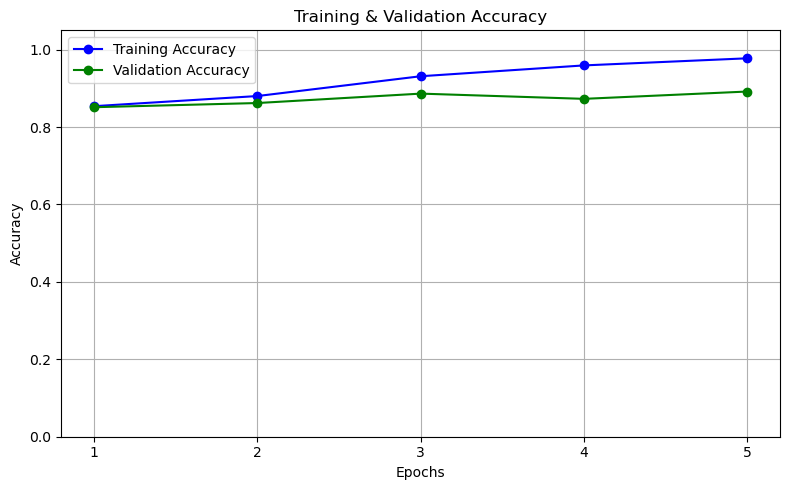

In [129]:
# Plot Training History
# your code here
# Extract metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(list(range(1,6)))
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">  

**3.8 - BERT Model Results**


- Display a confusion matrix for your trained BERT model.
- Decode and display 2 abstracts the model considered highly *not irrelevant*
- Do the same for 2 abstracts considered highly *not relevant* by the model
- Comment on the confusion matrix, example abstracts, and what you observed in the training history plot.
  
</div>

In [130]:
# Predictions
# your code here
pred_logits = model.predict(validation_data).logits
y_pred = np.argmax(pred_logits, axis=1)

12/12 [==============================] - 4s 307ms/step


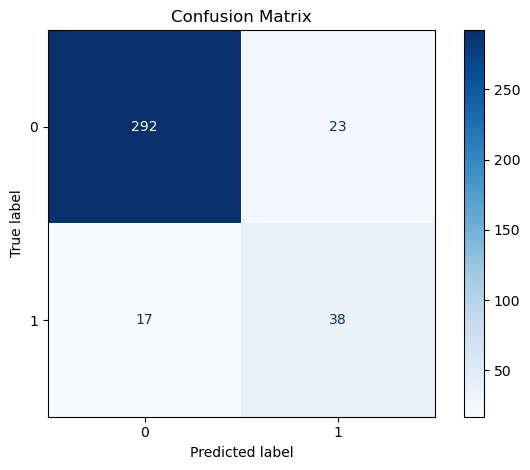

In [131]:
# Confusion Matrix
# your code here
y_true = np.array(validate_y)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [132]:
n_examples = 2 
irrel_bert = np.argsort(pred_logits[:, 1])[:n_examples]
# irrel_bert = np.argsort(pred_logits[:, 1])[:n_examples]

print(f"Highest predicted probabilities of being irrelevant\n")

for idx in irrel_bert:
    abstract = tokenizer.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

Highest predicted probabilities of being irrelevant

Abstract 43: hiv prevention programmes require scaling up in southern africa, and interventions that target people living with hiv / aids ( positive prevention ) should be included in all comprehensive hiv prevention plans. positive prevention interventions have been tested in the usa and have been demonstrated effective in reducing hiv transmission risks. lessons learned from us trials can be used in selecting and adapting positive prevention interventions for use in southern africa. efforts to implement positive prevention will be enhanced by reducing institutionalised aids stigmas and culturally held aids denialism and by increasing access to hiv / aids care services including antiretroviral therapies and sexually transmitted infection detection and treatment. positive prevention should not replace, but rather should augment, generalised hiv prevention interventions targeting high - risk populations.

Abstract 104: objective : thi

In [133]:
irrel_bert = np.argsort(pred_logits[:, 1])[-n_examples:]

print(f"Highest predicted probabilities of being NOT irrelevant\n")

for idx in irrel_bert:
    abstract = tokenizer.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

Highest predicted probabilities of being NOT irrelevant

Abstract 109: introduction in light of the limited impact the syndromic management approach has had on the global sexually transmitted infection ( sti ) epidemic, we assessed a care model comprising point - of - care ( poc ) sti testing, immediate treatment, and expedited partner therapy ( ept ) among a cohort of young women at high hiv risk in south africa. methods and findings hiv negative women presenting for sti care underwent poc testing for chlamydia trachomatis ( ct ), neisseria gonorrhoeae ( ng ) and trichomonas vaginalis ( tv ), and swabs were sent for ng culture and susceptibility testing. results were available within 2 hours and women with stis were immediately treated and offered ept packs, including medication, condoms, and information for sexual partners. an ept questionnaire was administered after one week, and women retested for stis after 6 and 12 weeks. 267 women, median age 23 ( iqr 21 – 26 ), were recruited a

In [134]:
# #chatgpt
# n_examples = 2

# # Lowest scores for class 1 → highest confidence in "irrelevant" (class 0)
# most_irrelevant = np.argsort(pred_logits[:, 1])[:n_examples]

# # Highest scores for class 1 → most confident it's relevant
# most_relevant = np.argsort(pred_logits[:, 1])[-n_examples:]
# print("❌ Highest confidence predictions for 'Not Relevant':\n")
# for idx in most_irrelevant:
#     abstract = tokenizer.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
#     print(f"Abstract {idx}:\n{abstract}\n")

# print("✅ Highest confidence predictions for 'Relevant':\n")
# for idx in most_relevant:
#     abstract = tokenizer.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
#     print(f"Abstract {idx}:\n{abstract}\n")


Comment on the confusion matrix, example abstracts, and what you observed in the training history plot.

1. Confusion Matrix: What I see in the confusion matrix is an accurate model. The majority of the predictions (288) were true negatives, whilst the second most predictions were true positives (40), followed by false positives (27) and false negative (15). Essentially, my model for the most part classified the irrelevant and relevant abstracts correctly.

2. What I observed in the training history plot confirmed this assertion that I have an accurate model. My model had relatively high training accuracy and validation accuracy from the get-go, starting at around 83% for both and ending up at around 88-90% for both.

3. Looking at the abstracts, I am a bit puzzled. On the one hand, I am confused because the two most irrelevant abstracts have to do with HIV/STD prevention and education programs. However, a quick glance at the abstracts of the three original datasets shows that all the abstracts are about STDs and STD prevention, so this is a concern to be put on the shelf. If we take a closer look at these abstracts, we can see they do not serve the target of this research which is to provide education to women who have HIV and are living in South-Saharan Africa. This is confirmed when looking at the two most relevant abstracts. They both deal with South-Saharan African women and STD education, prevention, and care programs.




<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">  

**3.8 - [209] DeBERTa**

**All subsequent questions (3.8-3.10) are required for AC209b students but optional for others.**

Repeat the tokenization, pipeline, model building, and fitting steps above (3.4-3.7), but now for the [DeBERTa](https://huggingface.co/docs/transformers/model_doc/deberta) base model. Specifically, we'll use the [V3](https://huggingface.co/microsoft/deberta-v3-base) model (`'microsoft/deberta-v3-base'`).  You may be able to use code from the previous BERT model questions if you wrote utility functions. 

**Notes:**
- You may want to 'freeze' some of the earlier layers (e.g., `deberta.layers[0].encoder.layer[i].trainable = False`)
- You can adjust the model's dropout rate by setting `deberta.layers[0].config.hidden_dropout_prob`
- You may want to explore more Keras callbacks such as `LearningRateScheduler` and `ReduceLROnPlateau` to make the learning rate more flexible during training.
  
**Don't forget to display important output like the model's summary and a plot of the training history!**

</div>

In [117]:
# Tokenization & Pipelines
# your code here
...

Ellipsis

In [118]:
# Build DeBERTa
# your code here
...

Ellipsis

In [119]:
# Train DeBERTa
# your code here
...

Ellipsis

In [120]:
#### Plot Training History
# your code here
...

Ellipsis

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;">  

**3.9 - [209] DeBERTa vs BERT Result**


- Display confusion matrices for both the BERT and DeBERTa models.
- Decode and display 4 abstracts considered highly *not irrelevant* by the two models (two from each)
- Do the same for 4 abstracts considered highly *not relevant* by the two models
  
</div>

In [121]:
# Predictions
# your code here
...

Ellipsis

In [122]:
# Confusion Matrices
# your code here
...

Ellipsis

In [123]:
n_examples = 2 
irrel_bert = np.argsort(y_pred_bert.logits[:, 1])[:n_examples]
irrel_deberta = np.argsort(y_pred_deberta.logits[:, 1])[:n_examples]

print(f"Highest predicted probabilities of being irrelevant\n")

print(f"BERT:")
for idx in irrel_bert:
    abstract = tokenizer_bert.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

print(f"DeBERTa:")
for idx in irrel_deberta:
    abstract = tokenizer_deberta.decode(validate_x_processed_deberta['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

NameError: name 'y_pred_bert' is not defined

In [ ]:
irrel_bert = np.argsort(y_pred_bert.logits[:, 1])[-n_examples:]
irrel_deberta = np.argsort(y_pred_deberta.logits[:, 1])[-n_examples:]

print(f"Highest predicted probabilities of being NOT irrelevant\n")

print(f"BERT:")
for idx in irrel_bert:
    abstract = tokenizer_bert.decode(validate_x_processed['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

print(f"DeBERTa:")
for idx in irrel_deberta:
    abstract = tokenizer_deberta.decode(validate_x_processed_deberta['input_ids'][idx], skip_special_tokens=True)
    print(f"Abstract {idx}: {abstract}\n")

<div class="alert alert-success" style="color: #333; background-color: #e8fffb; border-color: #bcfff2; border-width: 1px; border-radius: 3px; padding: 10px;"> 

**3.10 - [209] DeBERTa vs BERT Model Comparison**
    
Finally, address the following questions in the markdown cell provided:
- Based on the earlier plotted training histories  what are your thoughts on the performance of the two models both in absolute terms and with respect to one another?
- Based on the confusion matrices do you see a significant difference in the types of errors each model makes?
- Are you convinced by the abstracts displayed above that the models are performing well in their classification task?  Are the results qualitatively distinct between the two models?
- Did you end up using identical hyperparameters and training procedures for both models? Why or why not?
- What are 2 ways in which the DeBERTa model's use of poisitional encoding differs from the approach desribed in the lecture on BERT? (You may want to peruse [the original paper](https://arxiv.org/abs/2006.03654) for insights.)
</div>

*your answer here*



<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>



The most challenging aspect of this model was the first part, the poem RNN, because training took so long. In part 2 I ran into a problem where I used a TimeDistributed layer and that screwed up my training process, and it took a while to solve this error. Otherwise, this was an enjoyable pset! 

In [124]:
hours_spent_on_hw = 17

In [125]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [126]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 25.99 minutes for this notebook to run


**This concludes HW4. Thank you!**

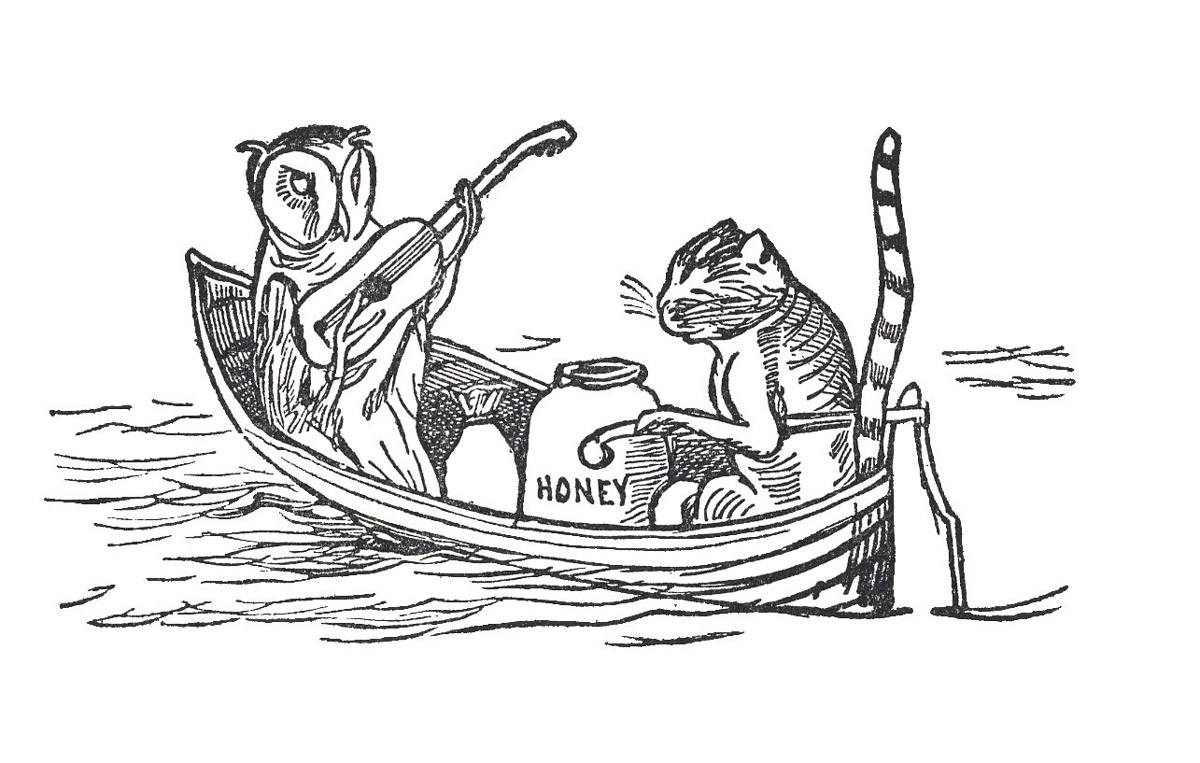